<div class="alert alert-block alert-info">
    <h1>Análisis de Series Temporales</h1>
    <h3>Clase 3</h3>
    <h3>Ejercicio 1</h3>
        <p>Docente: Rodrigo Del Rosso<p>
        <p>Asistentes: Sebastián Calcagno y Braian Drago<p>
</div>

<!DOCTYPE html>
<html lang="es">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Datos de Turismo</title>
</head>
<body>
    <p>
        Los datos se obtienen de la siguiente fuente:
        <a href="https://datos.gob.ar/dataset/turismo-encuesta-ocupacion-hotelera-parahotelera-eoh/archivo/turismo_d1624c27-4b0d-4b73-b0f8-e7db5c56386f" target="_blank">
            https://datos.gob.ar/dataset/ turismo-encuesta-ocupacion-hotelera-parahotelera-eoh/archivo/turismo_d1624c27-4b0d-4b73-b0f8-e7db5c56386f
        </a>. <br>
        Es la cantidad de viajeros alojados en establecimientos hoteleros y parahoteleros según residencia en formato de series de tiempo.
    </p>
</body>
</html>


# Carga de librerias y preparacion de las bases a trabajar

In [ ]:
!pip install pmdarima

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import statsmodels.tsa.stattools as tsa
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima.utils import ndiffs
from pmdarima.arima import ADFTest
from matplotlib import pyplot

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima, ndiffs, nsdiffs
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_breusch_godfrey
from scipy.stats import jarque_bera, shapiro, boxcox, probplot
from datetime import timedelta

In [ ]:
import statsmodels.api as sm

In [ ]:
# Esta función descompone la serie en sus partes para ver estacionalidad, tendencia, residuos
def componentes(timeserie):
  decomposition = seasonal_decompose(timeserie, period=12)
  fig = plt.figure()
  fig = decomposition.plot()
  fig.set_size_inches(15, 8)

In [ ]:
url='https://raw.githubusercontent.com/sebcalcagno/AnalisisSeriesTemporales/main/base_clase4.csv'
serie_inicial = pd.read_csv(url)

In [ ]:
serie_inicial.head()

,indice_tiempo,origen_viajeros,viajeros,observaciones
0,2007-01-01,Residentes,1679499,NaN
1,2007-01-01,No residentes,464201,NaN
2,2007-02-01,Residentes,1493372,NaN
3,2007-02-01,No residentes,479876,NaN
4,2007-03-01,Residentes,1285612,NaN


In [ ]:
serie_inicial.indice_tiempo = pd.to_datetime(serie_inicial.indice_tiempo)#, dayfirst = True)

In [ ]:
serie_inicial.dtypes

,0
indice_tiempo,datetime64[ns]
origen_viajeros,object
viajeros,int64
observaciones,object


In [ ]:
serie_inicial.set_index("indice_tiempo", inplace=True)

In [ ]:
serie_inicial.head()

,origen_viajeros,viajeros,observaciones
indice_tiempo,,,
2007-01-01,Residentes,1679499,NaN
2007-01-01,No residentes,464201,NaN
2007-02-01,Residentes,1493372,NaN
2007-02-01,No residentes,479876,NaN
2007-03-01,Residentes,1285612,NaN


In [ ]:
# Verificamos que el indice sea del tipo DatetimeIndex
print(serie_inicial.index)

# Exploramos los primeros y los ultimos datos de la serie
print(serie_inicial)

DatetimeIndex(['2007-01-01', '2007-01-01', '2007-02-01', '2007-02-01',
               '2007-03-01', '2007-03-01', '2007-04-01', '2007-04-01',
               '2007-05-01', '2007-05-01',
               ...
               '2021-12-01', '2021-12-01', '2022-01-01', '2022-01-01',
               '2022-02-01', '2022-02-01', '2022-03-01', '2022-03-01',
               '2022-04-01', '2022-04-01'],
              dtype='datetime64[ns]', name='indice_tiempo', length=368, freq=None)
              origen_viajeros  viajeros    observaciones
indice_tiempo                                           
2007-01-01         Residentes   1679499              NaN
2007-01-01      No residentes    464201              NaN
2007-02-01         Residentes   1493372              NaN
2007-02-01      No residentes    479876              NaN
2007-03-01         Residentes   1285612              NaN
...                       ...       ...              ...
2022-02-01      No residentes    115315  Dato provisorio
2022-03-01    

In [ ]:
# Removemos la fila de observaciones ya que no aporta informacion relevante.
serie_inicial = serie_inicial.drop(['observaciones'],axis=1)

# Filtramos las series
# Nos quedamos con la serie de residentes
serie_residentes = serie_inicial[serie_inicial["origen_viajeros"]=="Residentes"].drop("origen_viajeros",axis=1)
serie_no_residentes = serie_inicial[serie_inicial["origen_viajeros"]=="No residentes"].drop("origen_viajeros",axis=1)

In [ ]:
serie_residentes.head()

,viajeros
indice_tiempo,
2007-01-01,1679499
2007-02-01,1493372
2007-03-01,1285612
2007-04-01,1184937
2007-05-01,1017821


In [ ]:
print(type(serie_residentes))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
# Conviertimos el dataframe en una serie
serie_residentes = serie_residentes.iloc[:,0]

# Verificamos que sea una serie
print(type(serie_residentes))

# Utilizamos la funcion de Pandas para inferir la frequencia (mensual)
serie_residentes = serie_residentes.asfreq(pd.infer_freq(serie_residentes.index))

# Corroboramos que la frecuencia sea mensual -> freq='MS'
print(serie_residentes.index)

serie_residentes = pd.Series(serie_residentes[serie_residentes.index <= '2020-01-01'])

<class 'pandas.core.series.Series'>
DatetimeIndex(['2007-01-01', '2007-02-01', '2007-03-01', '2007-04-01',
               '2007-05-01', '2007-06-01', '2007-07-01', '2007-08-01',
               '2007-09-01', '2007-10-01',
               ...
               '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01'],
              dtype='datetime64[ns]', name='indice_tiempo', length=184, freq='MS')


In [ ]:
# Funcion para graficar.
def graficar(serie, titulo="", xlabel="Año", ylabel="Pasajeros"):
    fig_x = plt.figure(figsize=(12,3), dpi=100)
    axes_x = fig_x.add_axes([0.0, 0.0, 1, 1])
    serie.plot()
    axes_x.set_xlabel(xlabel)
    axes_x.set_ylabel(ylabel)
    axes_x.set_title(titulo)
    axes_x.legend(loc=0)
    axes_x.grid(True, color='0.6', dashes=(5,2,1,2))

In [ ]:
## Función para dibujar juntos FAS: autocovarianzas; FAC y FACP, autocorrelación y autocorrelación parcial
def autocov_autocorr(serie_r, nrol=75):
    fig, axes = plt.subplots(3, 1, figsize=(18, 10))

    plot_acf(serie_r, lags=nrol, ax=axes[0], color='blue', vlines_kwargs={"colors": 'blue'})
    axes[0].set_title('ACF (Autocorrelación)', fontsize=14)

    plot_pacf(serie_r, lags=nrol, ax=axes[1], color='green', vlines_kwargs={"colors": 'green'}, method='ywm')
    axes[1].set_title('PACF (Autocorrelación Parcial)', fontsize=14)

    axes[2].plot(tsa.acovf(serie_r, fft=False, nlag=nrol), color='red', label='AutoCov')
    axes[2].set_title('Autocovarianza', fontsize=14)
    axes[2].set_xlabel('Lag')

    plt.tight_layout()
    plt.show()

In [ ]:
serie_residentes.head()

,viajeros
indice_tiempo,
2007-01-01,1679499
2007-02-01,1493372
2007-03-01,1285612
2007-04-01,1184937
2007-05-01,1017821


In [ ]:
# Verificamos si hay nulos, y corroboramos que no los hay
print(serie_residentes.isnull().values.any())

False


In [ ]:
serie_residentes.describe()

,viajeros
count,1.570000e+02
mean,1.279718e+06
std,2.132864e+05
min,8.217510e+05
25%,1.120143e+06
50%,1.265025e+06
75%,1.405891e+06
max,1.800900e+06


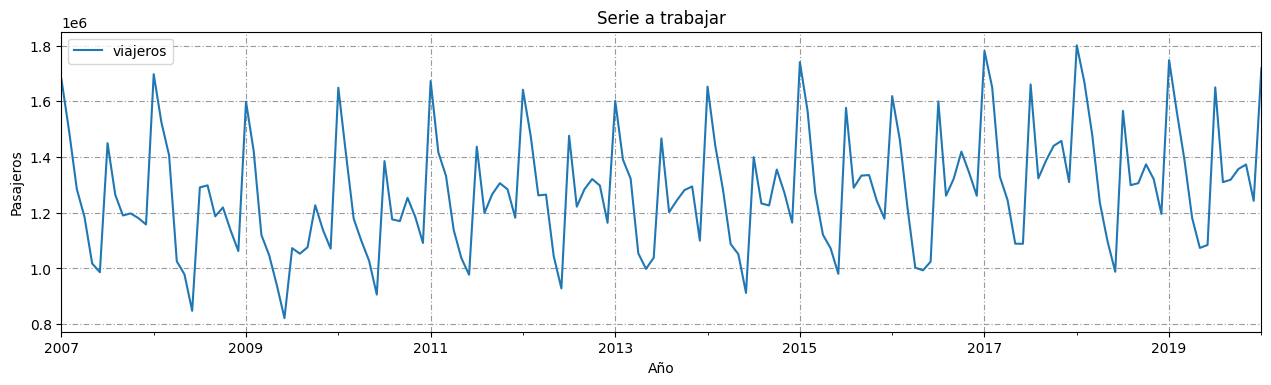

In [ ]:
graficar(serie_residentes, "Serie a trabajar")

In [ ]:
# Separacion Train/Test  ---> esta es otra variable a analizar
# Seleccionamos el primer 80% para train
train = serie_residentes.iloc[:round(len(serie_residentes)*.8)]
# Seleccionamos el 20% restante para test
test = serie_residentes.iloc[round(len(serie_residentes)*.8):]
# Corroboramos que los limites se hayan establecido segun lo planificado
print(train, test)

indice_tiempo
2007-01-01    1679499
2007-02-01    1493372
2007-03-01    1285612
2007-04-01    1184937
2007-05-01    1017821
               ...   
2017-02-01    1650309
2017-03-01    1329411
2017-04-01    1245606
2017-05-01    1088862
2017-06-01    1088614
Freq: MS, Name: viajeros, Length: 126, dtype: int64 indice_tiempo
2017-07-01    1660519
2017-08-01    1323414
2017-09-01    1386911
2017-10-01    1440231
2017-11-01    1457877
2017-12-01    1310199
2018-01-01    1800900
2018-02-01    1666664
2018-03-01    1480667
2018-04-01    1235730
2018-05-01    1097071
2018-06-01     988183
2018-07-01    1565479
2018-08-01    1298976
2018-09-01    1306121
2018-10-01    1373779
2018-11-01    1320392
2018-12-01    1195827
2019-01-01    1747922
2019-02-01    1562882
2019-03-01    1388867
2019-04-01    1180396
2019-05-01    1073666
2019-06-01    1084275
2019-07-01    1650061
2019-08-01    1309835
2019-09-01    1318472
2019-10-01    1356825
2019-11-01    1373087
2019-12-01    1242840
2020-01-01    1719

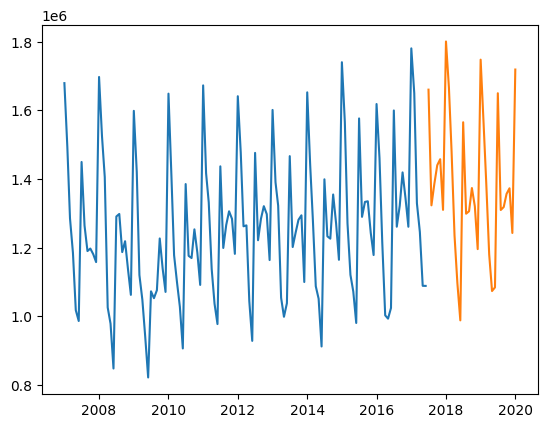

In [ ]:
plt.plot(train)
plt.plot(test)

In [ ]:
len(train)

126

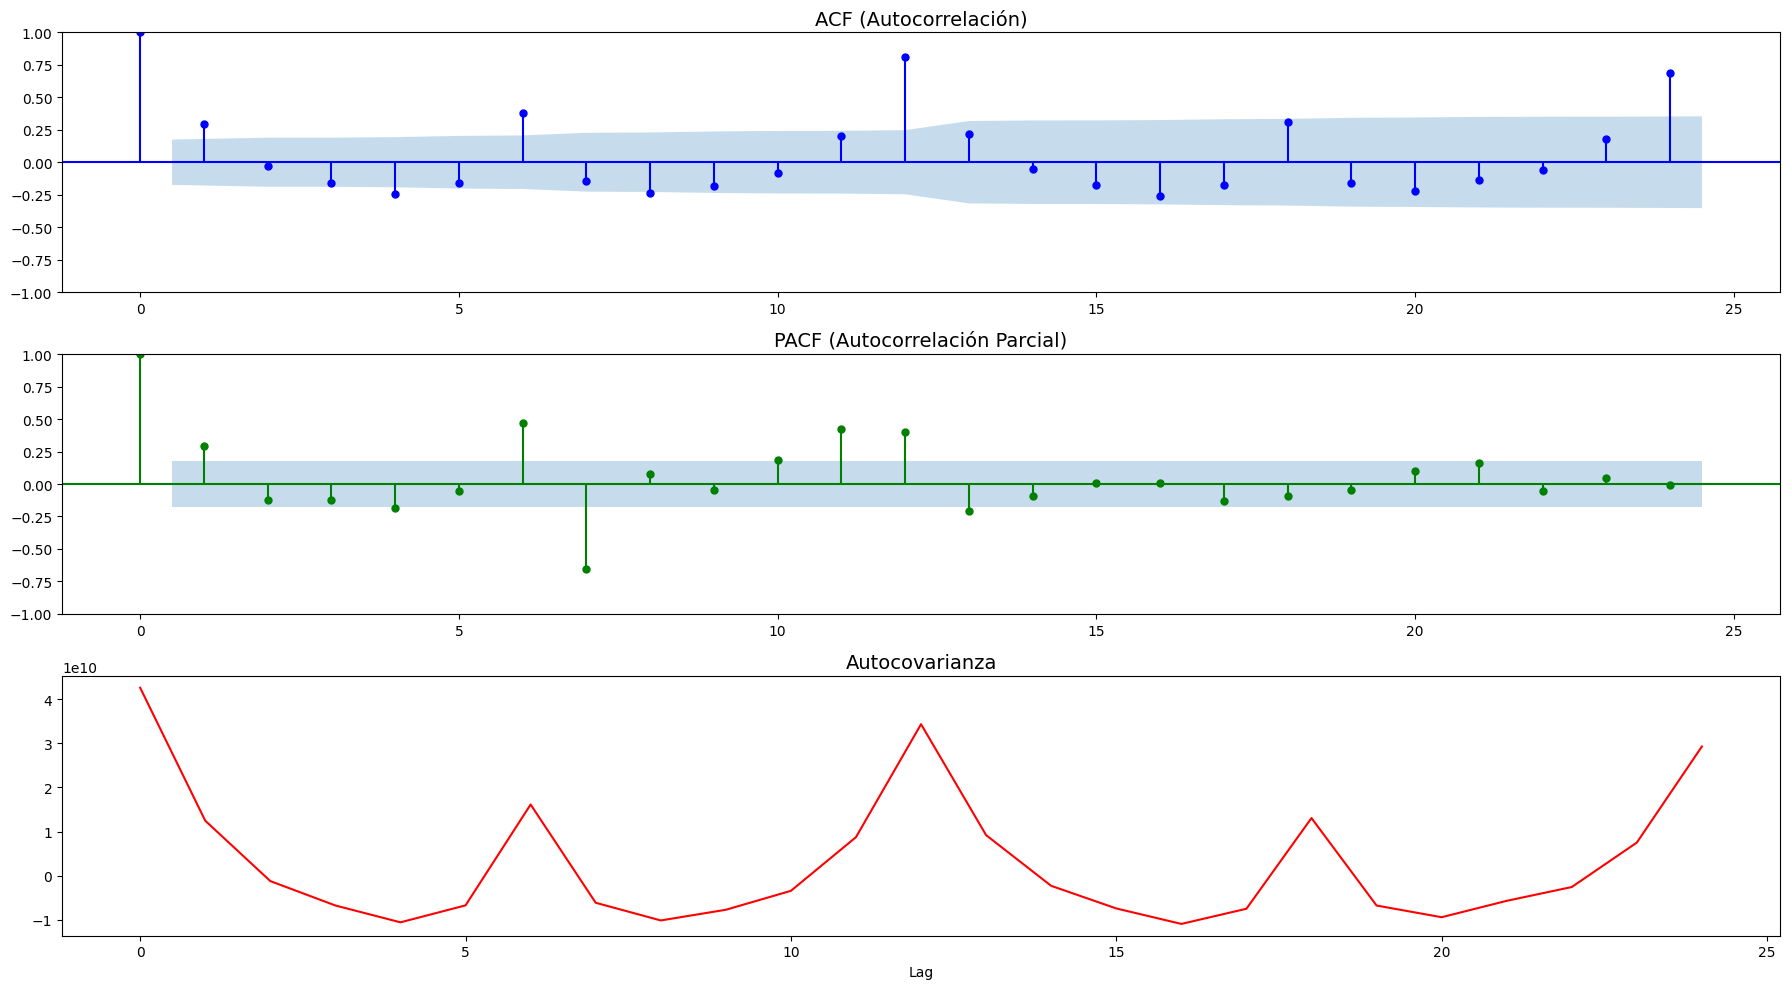

In [ ]:
# Grafica se puede ver la posible estacionalidad
autocov_autocorr(train ,24)

<Figure size 640x480 with 0 Axes>

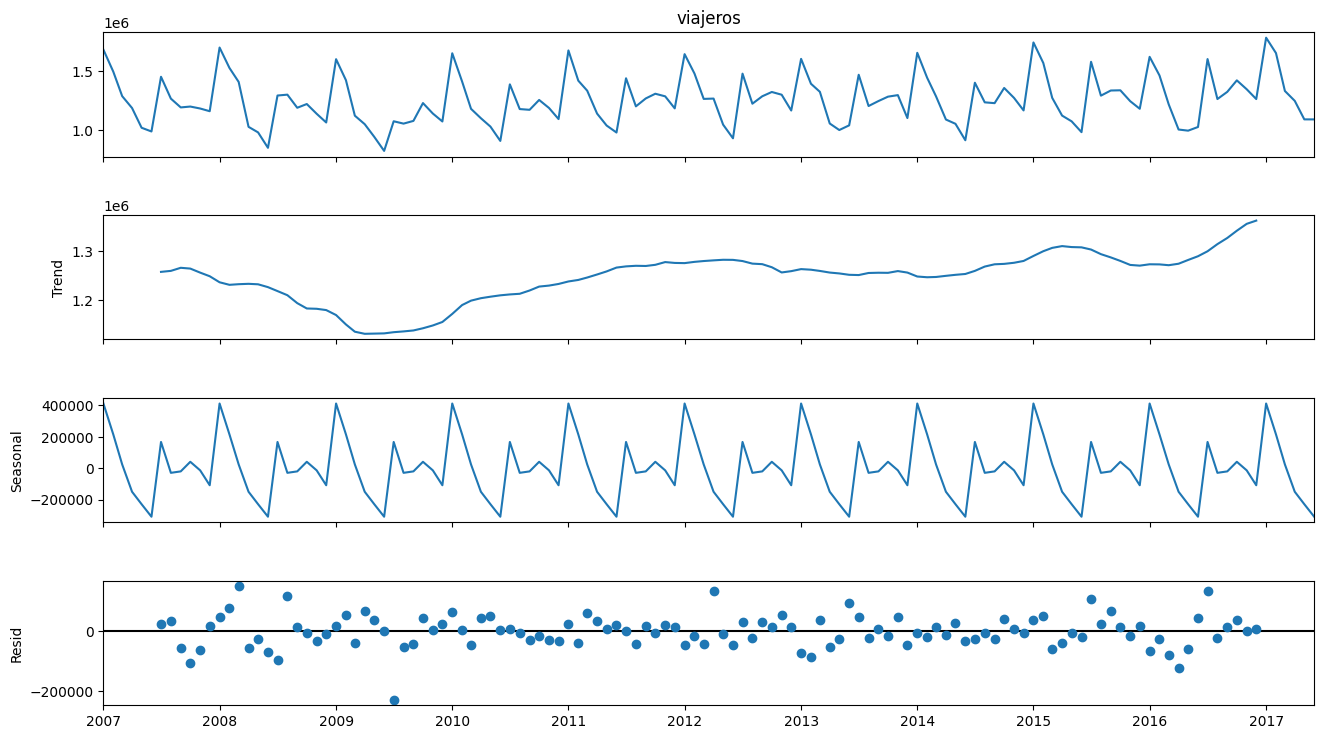

In [ ]:
componentes(train)

In [ ]:
def print_test_afd(y):
  resultado = tsa.adfuller(y)
  print('Estadistico ADF: %f' % resultado[0])
  print('p-valor: %f' % resultado[1])
  print('Valores criticos:')
  for key, valor in resultado[4].items():
    print('\t%s: %.3f' % (key, valor))

In [ ]:
def test_stationarity(timeseries):

    #Rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

Analisis de estacionariedad de las series de residentes

In [ ]:
print_test_afd(train)

Estadistico ADF: -0.881054
p-valor: 0.794148
Valores criticos:
	1%: -3.490
	5%: -2.888
	10%: -2.581


https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

Componentes deterministicos - Test de Raíces Unitarias - Dickey Fuller

In [ ]:
# No incluye término independiente ni lineal (“None”)
tsa.adfuller(train, maxlag=None, regression='n', autolag='AIC', store=False, regresults=False)

(0.50868060161908,
 0.8268648347259111,
 13,
 112,
 {'1%': -2.585991642219388,
  '5%': -1.9436442461108328,
  '10%': -1.614646876252733},
 2864.856711790934)

In [ ]:
# Incluya término independiente pero no incluye término lineal (“Drift”)
tsa.adfuller(train, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)

(-0.8810539020175625,
 0.7941475969756033,
 13,
 112,
 {'1%': -3.4901313156261384,
  '5%': -2.8877122815688776,
  '10%': -2.5807296460459184},
 2865.923321041762)

In [ ]:
# Incluya ambos términos (“Trend”) - se denomina Ecuación de Dickey Fuller Aumentada
tsa.adfuller(train, maxlag=None, regression='ct', autolag='AIC', store=False, regresults=False)

(-2.703238559215552,
 0.23474033065924355,
 13,
 112,
 {'1%': -4.041963001634247,
  '5%': -3.4504426407047193,
  '10%': -3.1504645425245994},
 2858.2142711627544)

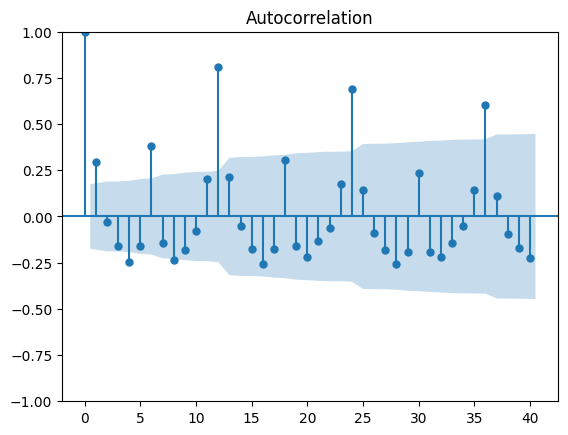

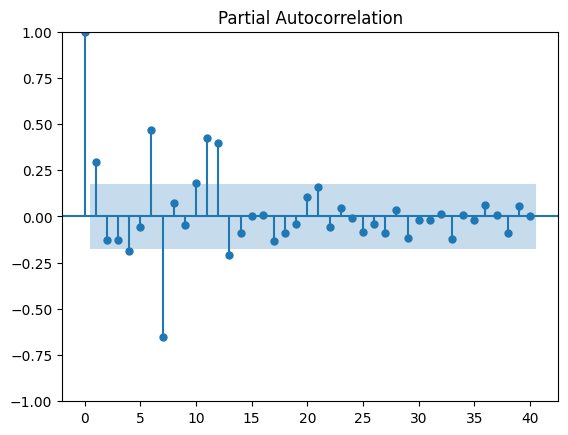

In [ ]:
plot_acf(train,lags=40);
plot_pacf(train,lags=40);

In [ ]:
def estacionario(y):
  # Estimado de número de diferencias con ADF test:Dickey-Fuller
  n_adf = ndiffs(y, test='adf')  # -> 0

  # KPSS test (auto_arima default): Kwiatkowski-Phillips-Schmidt-Shin
  n_kpss = ndiffs(y, test='kpss')  # -> 0

  # PP test: Phillips-Perron
  n_pp = ndiffs(y, test='pp')  # -> 0

  print('Estimado de número de diferencias con ADF test')
  print(n_adf)

  print('Estimado de número de diferencias con KPSS test')
  print(n_kpss)

  print('Estimado de número de diferencias con PP test')
  print(n_pp)

  print('Se debe realizar diferenciación (should_diff) ADF Test')
  adftest = ADFTest(alpha=0.05)
  print(adftest.should_diff(y))

#  Diferenciacion estacional de la serie original


In [ ]:
serie_residentes_cut_diff_12 = serie_residentes - serie_residentes.shift(12)
serie_residentes_cut_diff_12= serie_residentes_cut_diff_12.dropna()

# Separacion Train/Test
# Seleccionamos el primer 80% para train
train_diff_12 = serie_residentes_cut_diff_12.iloc[:round(len(serie_residentes_cut_diff_12)*.8)]
# Seleccionamos el 20% restante para test
test_diff_12 = serie_residentes_cut_diff_12.iloc[round(len(serie_residentes_cut_diff_12)*.8):]
# Corroboramos que los limites se hayan establecido segun lo planificado

,viajeros
indice_tiempo,
2008-01-01,17966.0
2008-02-01,31277.0
2008-03-01,120279.0
2008-04-01,-159279.0
2008-05-01,-39408.0
...,...
2017-04-01,242807.0
2017-05-01,95670.0
2017-06-01,64267.0


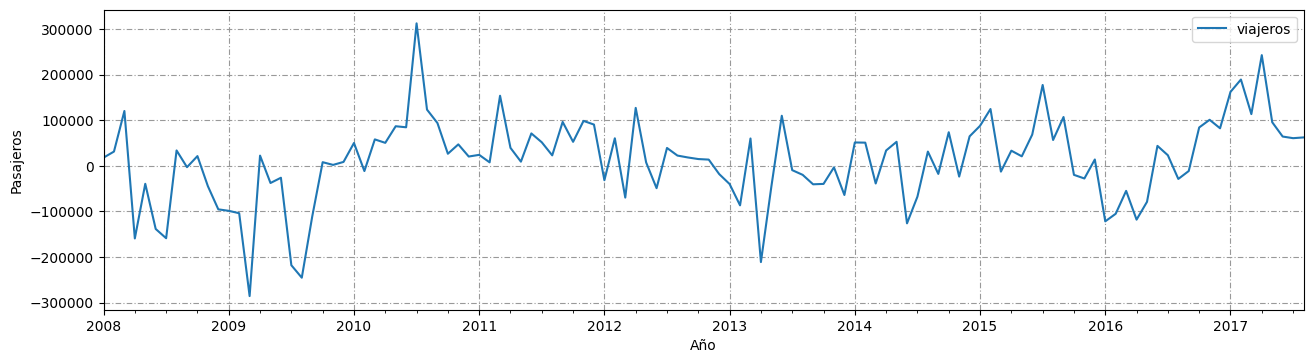

In [ ]:
# Para remover la estacionalidad anual, hacemos una diferencia de 12 meses
graficar(train_diff_12)
train_diff_12

In [ ]:
print_test_afd(train_diff_12)

Estadistico ADF: -2.433472
p-valor: 0.132511
Valores criticos:
	1%: -3.496
	5%: -2.890
	10%: -2.582


In [ ]:
# No incluye término independiente ni lineal (“None”)
tsa.adfuller(train_diff_12, maxlag=None, regression='n', autolag='AIC', store=False, regresults=False)

(-2.279008366065142,
 0.021807284242139423,
 13,
 102,
 {'1%': -2.588008223760092,
  '5%': -1.9439273444979683,
  '10%': -1.614453038574907},
 2585.9889464047874)

In [ ]:
# Incluya término independiente pero no incluye término lineal (“Drift”)
tsa.adfuller(train_diff_12, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)

(-2.4334720489596893,
 0.1325111323070971,
 13,
 102,
 {'1%': -3.4961490537199116,
  '5%': -2.8903209639580556,
  '10%': -2.5821223452518263},
 2586.763118615193)

In [ ]:
# Incluya ambos términos (“Trend”) - se denomina Ecuación de Dickey Fuller Aumentada
tsa.adfuller(train_diff_12, maxlag=None, regression='ct', autolag='AIC', store=False, regresults=False)

(-2.4990704739158875,
 0.3284271814990849,
 13,
 102,
 {'1%': -4.050384710217036,
  '5%': -3.454444406299236,
  '10%': -3.1527973675283265},
 2588.2801467521303)

A continuacion, analizamos mediante diferentes pruebas el orden de diferenciacion requerido para que la serie pueda llegar a ser estacionaria. Este es un analizis complementario, junto con los otros realizados. <br>
Las pruebas realizadas son:
<ol>
  <li>Prueba de Dickey-Fuller aumentada</li>
  <li>Prueba de Kwiatkowski-Phillips-Schmidt-Shin</li>
  <li>Prueba de Phillips-Perron</li>
</ol>

Las funciones de pmdarima son geniales pero no infalibles. Además, realmente depende de sus datos. La diferenciación es una excelente manera de hacer que los datos sean estacionarios, pero a veces no funciona. Por lo general, se usa para eliminar tendencias en los datos y la diferenciación estacional se usa para eliminar la estacionalidad.

In [ ]:
def estacionario(y):
  # Estimado de número de diferencias con ADF test:Dickey-Fuller
  n_adf = ndiffs(y, test='adf')  # -> 0

  # KPSS test (auto_arima default): Kwiatkowski-Phillips-Schmidt-Shin
  n_kpss = ndiffs(y, test='kpss')  # -> 0

  # PP test: Phillips-Perron
  n_pp = ndiffs(y, test='pp')  # -> 0

  print('Estimado de número de diferencias con ADF test')
  print(n_adf)

  print('Estimado de número de diferencias con KPSS test')
  print(n_kpss)

  print('Estimado de número de diferencias con PP test')
  print(n_pp)

  print('Se debe realizar diferenciación (should_diff) ADF Test')
  adftest = ADFTest(alpha=0.05)
  print(adftest.should_diff(y))

In [ ]:
estacionario(train_diff_12)

Estimado de número de diferencias con ADF test
1
Estimado de número de diferencias con KPSS test
0
Estimado de número de diferencias con PP test
0
Se debe realizar diferenciación (should_diff) ADF Test
(0.12386415585897369, True)


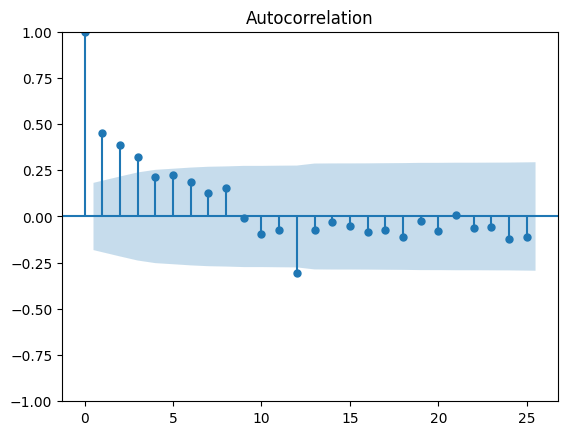

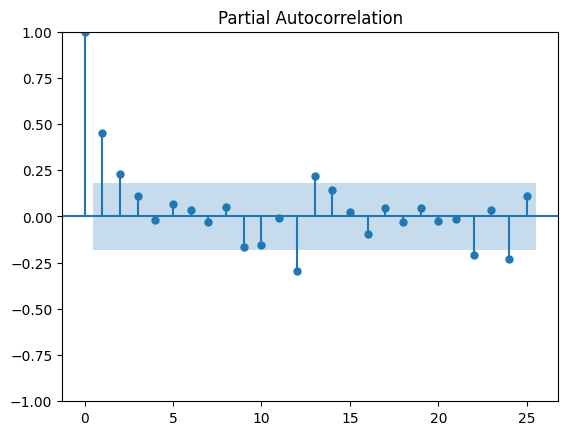

In [ ]:
plot_acf(train_diff_12,lags=25);
plot_pacf(train_diff_12,lags=25);

Realizamos una primera diferencia de la serie original

In [ ]:
serie_residentes_cut_diff_1 = serie_residentes - serie_residentes.shift(1)
serie_residentes_cut_diff_1= serie_residentes_cut_diff_1.dropna()

# Separacion Train/Test
# Seleccionamos el primer 80% para train
train_diff_1 = serie_residentes_cut_diff_1.iloc[:round(len(serie_residentes_cut_diff_1)*.8)]
# Seleccionamos el 20% restante para test
test_diff_1 = serie_residentes_cut_diff_1.iloc[round(len(serie_residentes_cut_diff_1)*.8):]
# Corroboramos que los limites se hayan establecido segun lo planificado

indice_tiempo
2007-02-01   -186127.0
2007-03-01   -207760.0
2007-04-01   -100675.0
2007-05-01   -167116.0
2007-06-01    -31433.0
                ...   
2017-02-01   -130508.0
2017-03-01   -320898.0
2017-04-01    -83805.0
2017-05-01   -156744.0
2017-06-01      -248.0
Freq: MS, Name: viajeros, Length: 125, dtype: float64


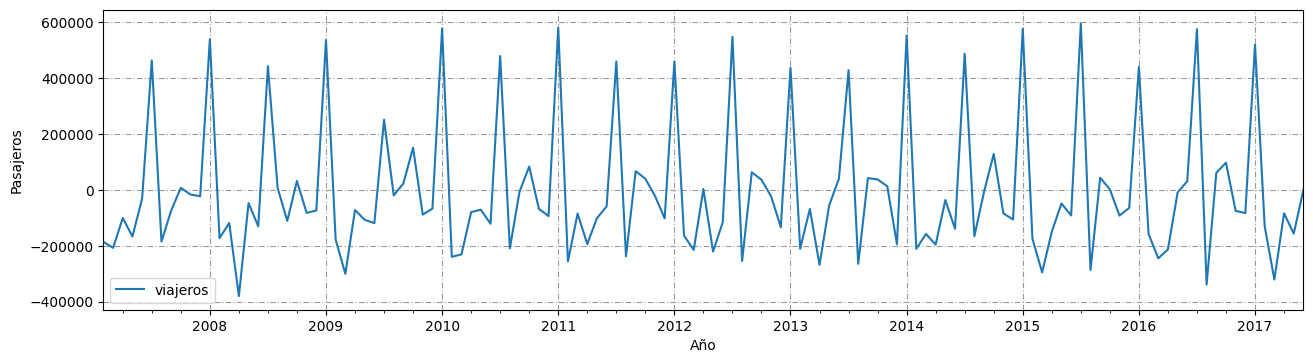

In [ ]:
graficar(train_diff_1)
print(train_diff_1)

In [ ]:
print_test_afd(train_diff_1)

Estadistico ADF: -3.885039
p-valor: 0.002148
Valores criticos:
	1%: -3.490
	5%: -2.888
	10%: -2.581


In [ ]:
# No incluye término independiente ni lineal (“None”)
tsa.adfuller(train_diff_1, maxlag=None, regression='n', autolag='AIC', store=False, regresults=False)

(-3.860768600713069,
 0.0001260637640177667,
 12,
 112,
 {'1%': -2.585991642219388,
  '5%': -1.9436442461108328,
  '10%': -1.614646876252733},
 2837.2534475407588)

In [ ]:
# Incluya término independiente pero no incluye término lineal (“Drift”)
tsa.adfuller(train_diff_1, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)

(-3.8850385223792543,
 0.002147756420929405,
 12,
 112,
 {'1%': -3.4901313156261384,
  '5%': -2.8877122815688776,
  '10%': -2.5807296460459184},
 2839.0313942043726)

In [ ]:
# Incluya ambos términos (“Trend”) - se denomina Ecuación de Dickey Fuller Aumentada
tsa.adfuller(train_diff_1, maxlag=None, regression='ct', autolag='AIC', store=False, regresults=False)

(-4.158091855110128,
 0.0051747658613272626,
 12,
 112,
 {'1%': -4.041963001634247,
  '5%': -3.4504426407047193,
  '10%': -3.1504645425245994},
 2837.7921334952284)

In [ ]:
estacionario(train_diff_1)

Estimado de número de diferencias con ADF test
0
Estimado de número de diferencias con KPSS test
0
Estimado de número de diferencias con PP test
0
Se debe realizar diferenciación (should_diff) ADF Test
(0.01, False)


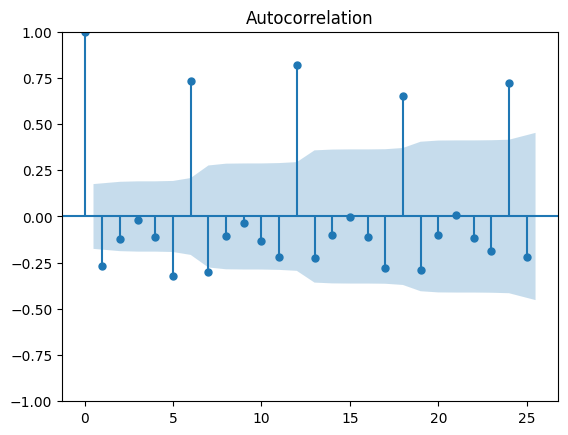

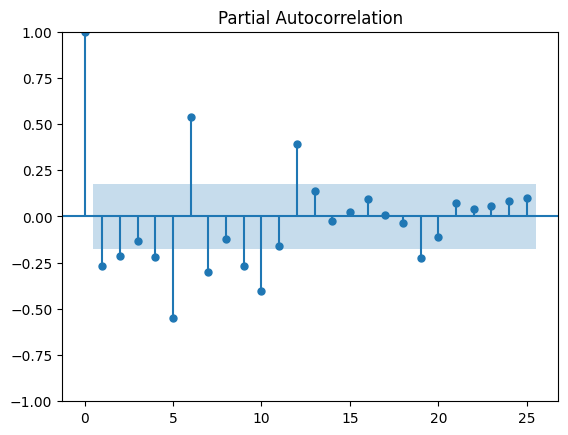

In [ ]:
plot_acf(train_diff_1,lags=25);
plot_pacf(train_diff_1,lags=25);

Ahora vemos la grafica de ACF y PACF para la serie diferenciada en orden 1 de Residentes, se observan picos, lo cual es un indicativo de estacionalidad. La autocorrelación parcial por otra parte, evidencia en los lagsl 1 y 2, los primeros puntos significativos a tener en cuenta para el orden de la autoregresión

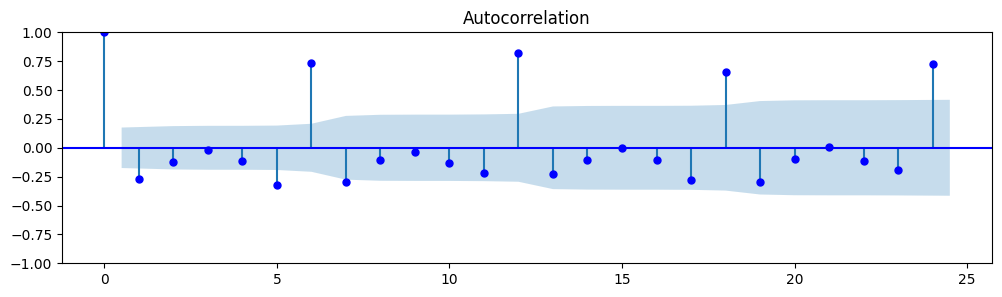

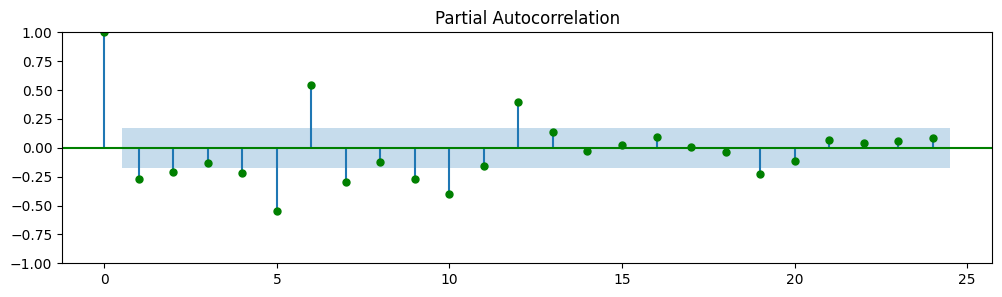

In [ ]:
acf_plot = plot_acf(train_diff_1, lags=24,  color= 'blue')
acf_plot.set_size_inches(12,3)

pacf_plot = plot_pacf(train_diff_1, lags=24, color= 'green')
pacf_plot.set_size_inches(12,3)

Diferenciamos estacionalmente la serie diferenciada

In [ ]:
serie_residentes_cut_diff_1_12 = serie_residentes_cut_diff_1 - serie_residentes_cut_diff_1.shift(12)
serie_residentes_cut_diff_1_12= serie_residentes_cut_diff_1_12.dropna()

# Separacion Train/Test
# Seleccionamos el primer 80% para train
train_diff_1_12 = serie_residentes_cut_diff_1_12.iloc[:round(len(serie_residentes_cut_diff_1_12)*.8)]
# Seleccionamos el 20% restante para test
test_diff_1_12 = serie_residentes_cut_diff_1_12.iloc[round(len(serie_residentes_cut_diff_1_12)*.8):]
# Corroboramos que los limites se hayan establecido segun lo planificado

,viajeros
indice_tiempo,
2008-02-01,13311.0
2008-03-01,89002.0
2008-04-01,-279558.0
2008-05-01,119871.0
2008-06-01,-99089.0
...,...
2017-04-01,129337.0
2017-05-01,-147137.0
2017-06-01,-31403.0


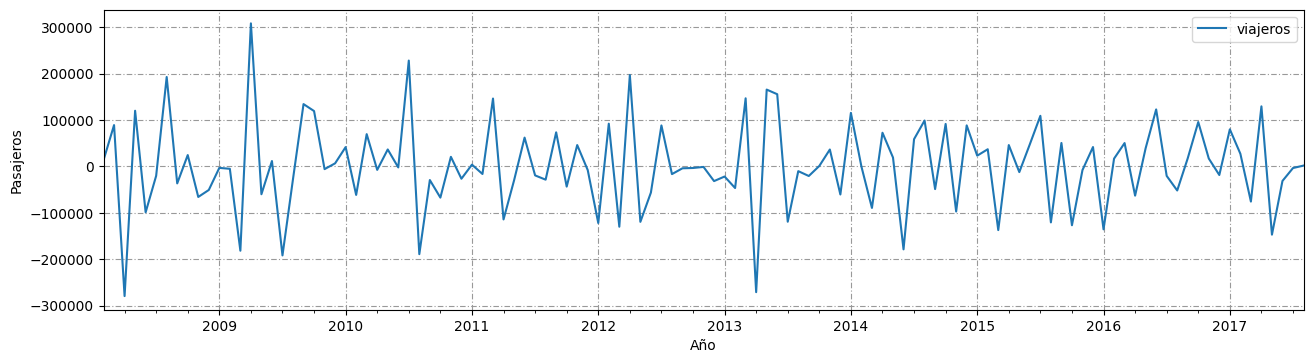

In [ ]:
# Para remover la estacionalidad anual, hacemos una diferencia de 12 meses y en el grafico ya no observamos
# un patron repetitivo

graficar(train_diff_1_12)
train_diff_1_12

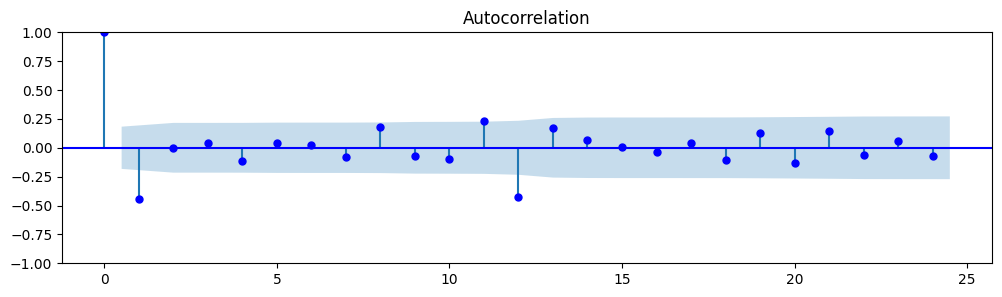

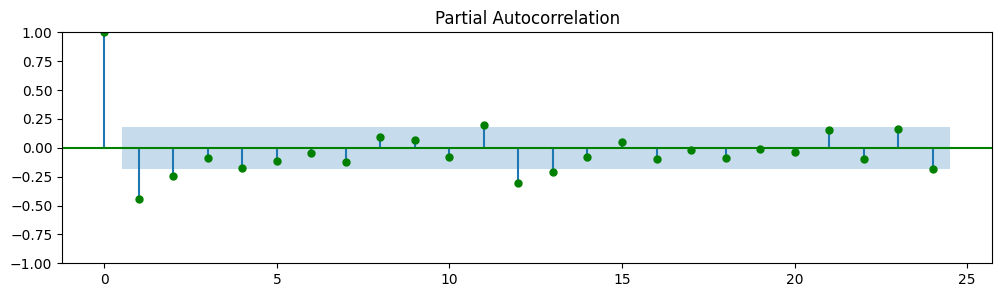

In [ ]:
acf_plot = plot_acf(train_diff_1_12, lags=24, color= 'blue')
pacf_plot = plot_pacf(train_diff_1_12, lags=24, color= 'green')

pacf_plot.set_size_inches(12,3)
acf_plot.set_size_inches(12,3)

In [ ]:
print_test_afd(train_diff_1_12)

Estadistico ADF: -4.487201
p-valor: 0.000207
Valores criticos:
	1%: -3.496
	5%: -2.890
	10%: -2.582


In [ ]:
# No incluye término independiente ni lineal (“None”)
tsa.adfuller(train_diff_1_12, maxlag=None, regression='n', autolag='AIC', store=False, regresults=False)

(-4.47148903593267,
 1.0656259835701633e-05,
 12,
 102,
 {'1%': -2.588008223760092,
  '5%': -1.9439273444979683,
  '10%': -1.614453038574907},
 2559.9418175632445)

In [ ]:
# Incluya término independiente pero no incluye término lineal (“Drift”)
tsa.adfuller(train_diff_1_12, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)

(-4.487200735362384,
 0.00020738083161237188,
 12,
 102,
 {'1%': -3.4961490537199116,
  '5%': -2.8903209639580556,
  '10%': -2.5821223452518263},
 2561.16892023002)

In [ ]:
# Incluya ambos términos (“Trend”) - se denomina Ecuación de Dickey Fuller Aumentada
tsa.adfuller(train_diff_1_12, maxlag=None, regression='ct', autolag='AIC', store=False, regresults=False)

(-4.435162759710347,
 0.0019232910748465406,
 12,
 102,
 {'1%': -4.050384710217036,
  '5%': -3.454444406299236,
  '10%': -3.1527973675283265},
 2562.71032554374)

In [ ]:
estacionario(train_diff_1_12)

Estimado de número de diferencias con ADF test
0
Estimado de número de diferencias con KPSS test
0
Estimado de número de diferencias con PP test
0
Se debe realizar diferenciación (should_diff) ADF Test
(0.01, False)


In [ ]:
# Funcion para graficar las predicciones.
# Toma como parametros:
# serie_test: la porcion de la serie con los datos de test
# serie_pred: las predicciones hechas por el modelo
# conf_int: el intervalo de confianza de las predicciones

def graficar_pred(serie_test, serie_pred, conf_int, titulo="Valores Originales vs Predicciones", xlabel="Año", ylabel="Pasajeros"):
    fig_x = plt.figure(figsize=(12,3), dpi=100)
    axes_x = fig_x.add_axes([0.0, 0.0, 1, 1])

    # Graficamos los datos tests y las predicciones
    serie_test.plot(label="Serie Original de Test")
    serie_pred.plot(label="Predicciones")

    # Pasamos dataframe con los intervalos de confianza a series de Pandas y graficamos
    conf_int.iloc[:,1].plot(label="Intervalo de Confianza Superior")
    conf_int.iloc[:,0].plot(label="Intervalo de Confianza Inferior")

    axes_x.set_xlabel(xlabel)
    axes_x.set_ylabel(ylabel)
    axes_x.set_title(titulo)
    axes_x.legend(loc=0)
    axes_x.grid(True, color='0.6', dashes=(5,2,1,2))

In [ ]:
def evaluar_metricas(serie_test, serie_pred):
    print(f'MSE: {mean_squared_error(serie_test, serie_pred)}')
    print(f'MAE: {mean_absolute_error(serie_test, serie_pred)}')
    print(f'RMSE: {np.sqrt(mean_squared_error(serie_test, serie_pred))}')
    print(f'MAPE: {round(np.mean(abs((serie_test-serie_pred)/serie_test)),4)}')

# MODELOS

MODELO ARMA

In [ ]:
# Aqui hacemos el loop probando diferentes "p" y "q", para saber cual es el criterio de informacion mas bajo.

import itertools
import statsmodels.api as sm

p_values = range(0, 3)
q_values = range(0, 3)


resultados = []
mejor_aic = float("inf")
mejor_order = None
mejor_modelo = None


for p, q in itertools.product(p_values, q_values):
    try:

        modelo = sm.tsa.arima.ARIMA(train_diff_1_12, order=(p, 0, q))
        resultado = modelo.fit()

        aic = resultado.aic
        resultados.append((p, q, aic))

        if aic < mejor_aic:
            mejor_aic = aic
            mejor_order = (p, q)
            mejor_modelo = resultado

    except Exception as e:
        print(f"Error en el modelo ARMA({p},{q}): {e}")

print(f"Mejor modelo ARMA: order={mejor_order} con AIC={mejor_aic}")

for p, q, aic in resultados:
    print(f"ARMA({p},{q}) AIC: {aic}")


Mejor modelo ARMA: order=(1, 2) con AIC=2933.7460508766144
ARMA(0,0) AIC: 3401.570015894159
ARMA(0,1) AIC: 2935.423501510881
ARMA(0,2) AIC: 2937.2204296818145
ARMA(1,0) AIC: 2947.2098159464676
ARMA(1,1) AIC: 2936.9562904705163
ARMA(1,2) AIC: 2933.7460508766144
ARMA(2,0) AIC: 2942.2600563946794
ARMA(2,1) AIC: 2934.770311857889
ARMA(2,2) AIC: 2935.685442972327


In [ ]:
from statsmodels.tsa.arima_model import ARMA

import statsmodels.api as sm
modeloARMA = sm.tsa.arima.ARIMA(train_diff_1_12, order=(1,0,2))
resultadoARMA = modeloARMA.fit()

resultadoARMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               viajeros   No. Observations:                  115
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -1461.873
Date:                Tue, 08 Oct 2024   AIC                           2933.746
Time:                        23:36:40   BIC                           2947.471
Sample:                    02-01-2008   HQIC                          2939.317
                         - 08-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        386.0750    653.312      0.591      0.555    -894.393    1666.543
ar.L1          0.8214      0.143      5.759      0.000       0.542       1.101
ma.L1         -1.4930      0.189     -7.882      0.000      -1.864      -1.122
ma.L2          0.4933      0.185      2.669      0.008       0.131       0.856
sigma2      6.351e+09   7.85e-06   8.09e+14      0.000    6.35e+09    6.35e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 5.79
Prob(Q):                              0.87   Prob(JB):                         0.06
Heteroskedasticity (H):               0.47   Skew:                            -0.13
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.44e+32. Standard errors may be unstable.
"""

In [ ]:
# Vemos que el componente "const" da un "p>Z" en modulo mayor a 0.05. Por lo tanto lo eliminamos

modeloARMA = sm.tsa.arima.ARIMA(train_diff_1_12, order=(1,0,2), trend='n')
resultadoARMA_2 = modeloARMA.fit()


print(resultadoARMA_2.summary())

                               SARIMAX Results                                
Dep. Variable:               viajeros   No. Observations:                  115
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -1462.387
Date:                Tue, 08 Oct 2024   AIC                           2932.774
Time:                        23:37:38   BIC                           2943.754
Sample:                    02-01-2008   HQIC                          2937.231
                         - 08-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8478      0.125      6.779      0.000       0.603       1.093
ma.L1         -1.5100      0.178     -8.491      0.000      -1.859      -1.161
ma.L2          0.5103      0.170      3.010      0.0

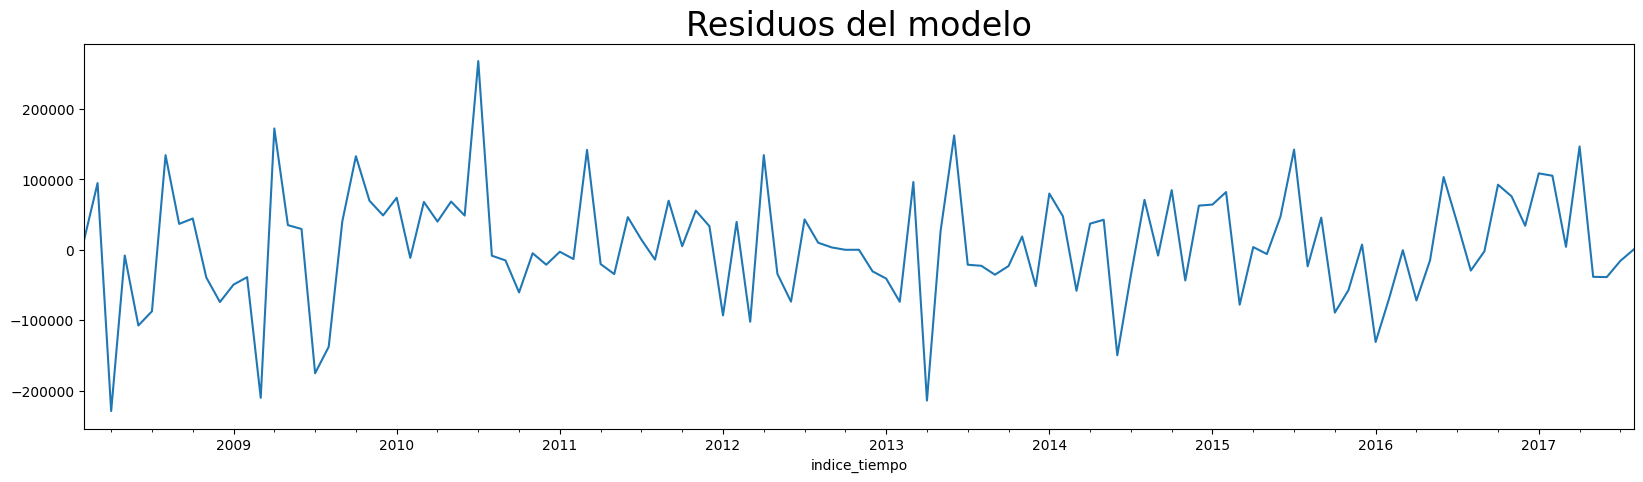

In [ ]:
resultadoARMA_2.resid.plot(figsize=(20,5))
plt.title("Residuos del modelo",size=24)
plt.show()

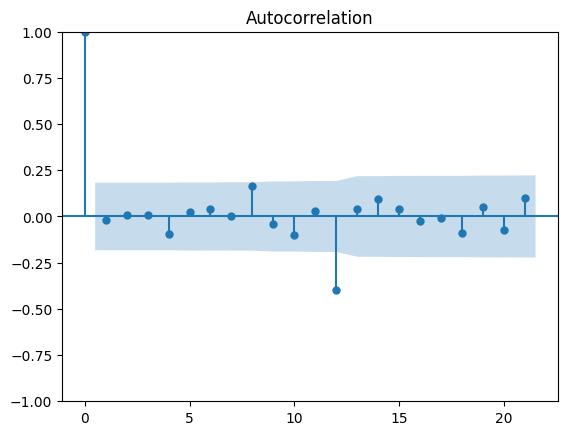

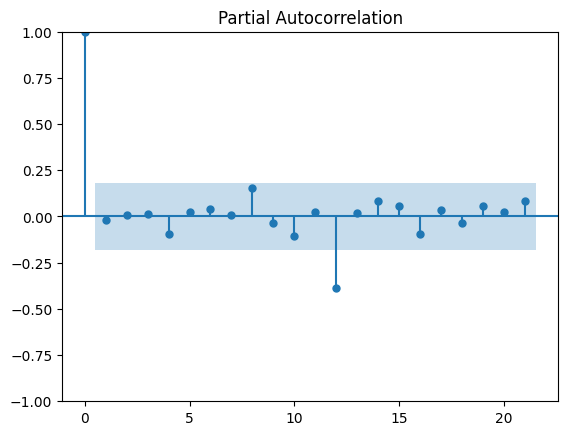

In [ ]:
plot_acf(resultadoARMA_2.resid);
plot_pacf(resultadoARMA_2.resid);

Text(0, 0.5, 'P-valores ')

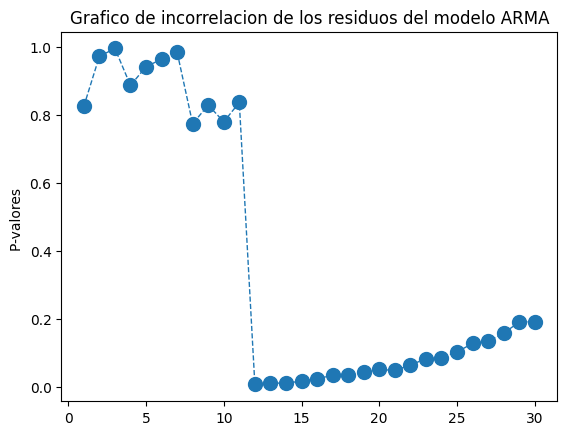

In [ ]:
Incorr_residuos_modelo_ARMA=sm.stats.acorr_ljungbox(resultadoARMA_2.resid, lags=30)
plt.plot(Incorr_residuos_modelo_ARMA.lb_pvalue, marker='o', markersize=10, linestyle='--', linewidth=1)
plt.title("Grafico de incorrelacion de los residuos del modelo ARMA")
plt.ylabel("P-valores ")

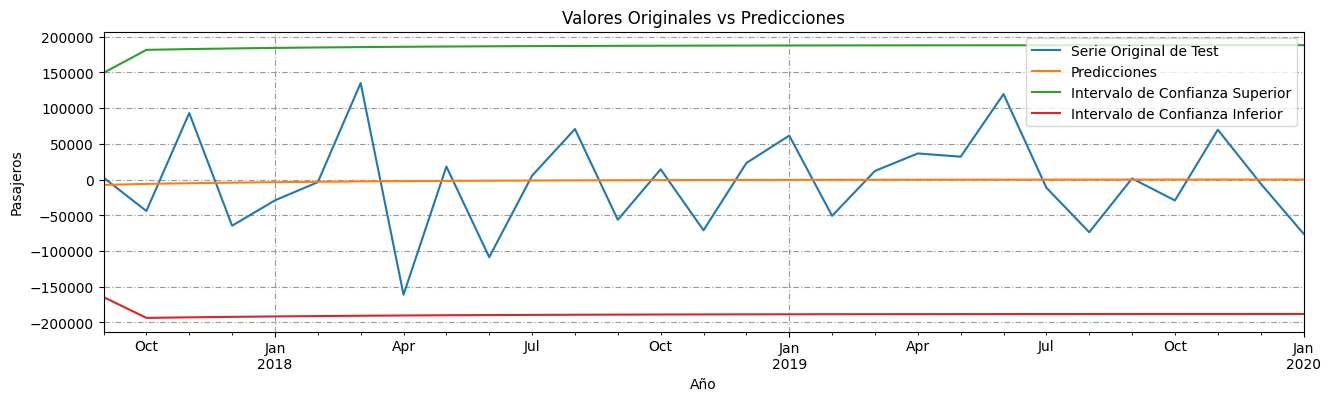

In [ ]:
# Utilizando el modelo realizamos la prediccion correspondiente al periodo de test
prediccionesARMA = resultadoARMA_2.get_forecast(len(test_diff_1_12))

# Graficamos la porcion de test de la serie original junto con las predicciones y los intervalos de confianza
graficar_pred(test_diff_1_12, prediccionesARMA.predicted_mean, prediccionesARMA.conf_int())

In [ ]:
evaluar_metricas(test_diff_1_12, prediccionesARMA.predicted_mean)

MSE: 4335869916.816756
MAE: 51006.74404628088
RMSE: 65847.32277637988
MAPE: 1.0817


**ARMA con otras transformaciones de la serie original - Vemos que arroja peores resultados.**

Recordando que esta seleccion de la serie transformada no es correcta si queremos trabajar con un modelo ARMA.

Problemas=
1- tendencia y la  2- estacionalidad. eso hace q las series no sean estacionarias. Entonces hay q quitar esos picos para q las series sean estacionarias.

El modelo ARMA es con datos estacionarios.

In [ ]:
import itertools
import statsmodels.api as sm

p_values = range(0, 3)
q_values = range(0, 3)

resultados = []
mejor_aic = float("inf")
mejor_order = None
mejor_modelo = None

for p, q in itertools.product(p_values, q_values):
    try:

        modelo = sm.tsa.arima.ARIMA(train_diff_1, order=(p, 0, q))    # ACA VA LA SERIE
        resultado = modelo.fit()

        aic = resultado.aic
        resultados.append((p, q, aic))

        if aic < mejor_aic:
            mejor_aic = aic
            mejor_order = (p, q)
            mejor_modelo = resultado

    except Exception as e:
        print(f"Error en el modelo ARMA({p},{q}): {e}")

print(f"Mejor modelo ARMA: order={mejor_order} con AIC={mejor_aic}")

for p, q, aic in resultados:
    print(f"ARMA({p},{q}) AIC: {aic}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mejor modelo ARMA: order=(0, 2) con AIC=3422.99801110757
ARMA(0,0) AIC: 3938.3813818438416
ARMA(0,1) AIC: 3433.6951856676487
ARMA(0,2) AIC: 3422.99801110757
ARMA(1,0) AIC: 3451.398773932806
ARMA(1,1) AIC: 3425.4940389718804
ARMA(1,2) AIC: 3433.578378306073
ARMA(2,0) AIC: 3447.5191149696293
ARMA(2,1) AIC: 3426.302923065484
ARMA(2,2) AIC: 3428.75479631989


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
from statsmodels.tsa.arima_model import ARMA

import statsmodels.api as sm
modeloARMA = sm.tsa.arima.ARIMA(train_diff_1, order=(0,0,2))
resultadoARMA = modeloARMA.fit()

resultadoARMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               viajeros   No. Observations:                  125
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -1707.499
Date:                Tue, 08 Oct 2024   AIC                           3422.998
Time:                        23:42:22   BIC                           3434.311
Sample:                    02-01-2007   HQIC                          3427.594
                         - 06-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4727.0799   3937.392     -1.201      0.230   -1.24e+04    2990.067
ma.L1         -0.5859      0.145     -4.033      0.000      -0.871      -0.301
ma.L2         -0.2825      0.155     -1.827      0.068      -0.586       0.021
sigma2      4.337e+10      0.002   2.27e+13      0.000    4.34e+10    4.34e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                20.53
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.96
Prob(H) (two-sided):                  0.65   Kurtosis:                         3.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.76e+31. Standard errors may be unstable.
"""

In [ ]:
from statsmodels.tsa.arima_model import ARMA

import statsmodels.api as sm
modeloARMA = sm.tsa.arima.ARIMA(train_diff_1, order=(0,0,1), trend='n')
resultadoARMA = modeloARMA.fit()

resultadoARMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               viajeros   No. Observations:                  125
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1710.665
Date:                Tue, 08 Oct 2024   AIC                           3425.329
Time:                        23:43:03   BIC                           3430.986
Sample:                    02-01-2007   HQIC                          3427.627
                         - 06-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9701      0.045    -21.697      0.000      -1.058      -0.882
sigma2      5.236e+10   5.91e-15   8.86e+24      0.000    5.24e+10    5.24e+10
===================================================================================
Ljung-Box (L1) (Q):                  11.67   Jarque-Bera (JB):                 4.43
Prob(Q):                              0.00   Prob(JB):                         0.11
Heteroskedasticity (H):               0.99   Skew:                             0.45
Prob(H) (two-sided):                  0.96   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

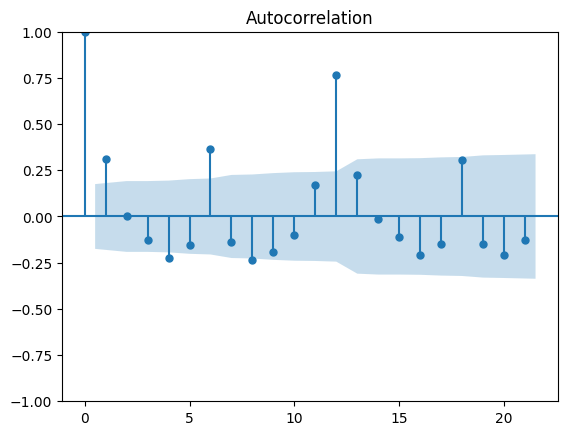

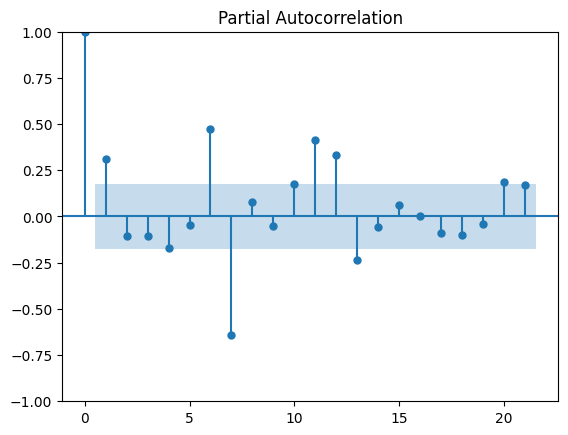

In [ ]:
plot_acf(resultadoARMA.resid);
plot_pacf(resultadoARMA.resid);

Text(0, 0.5, 'P-valores ')

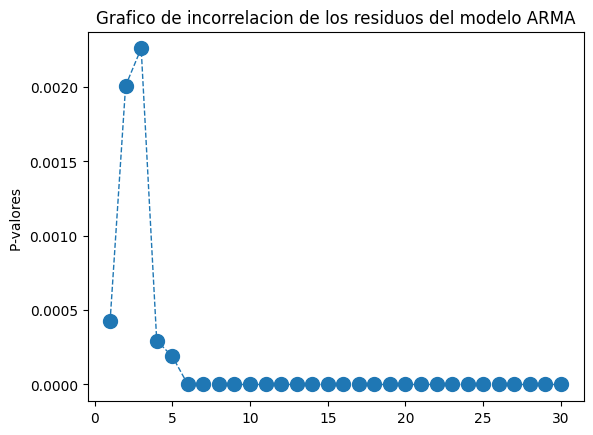

In [ ]:
Incorr_residuos_modelo_ARMA=sm.stats.acorr_ljungbox(resultadoARMA.resid, lags=30)
plt.plot(Incorr_residuos_modelo_ARMA.lb_pvalue, marker='o', markersize=10, linestyle='--', linewidth=1)
plt.title("Grafico de incorrelacion de los residuos del modelo ARMA")
plt.ylabel("P-valores ")

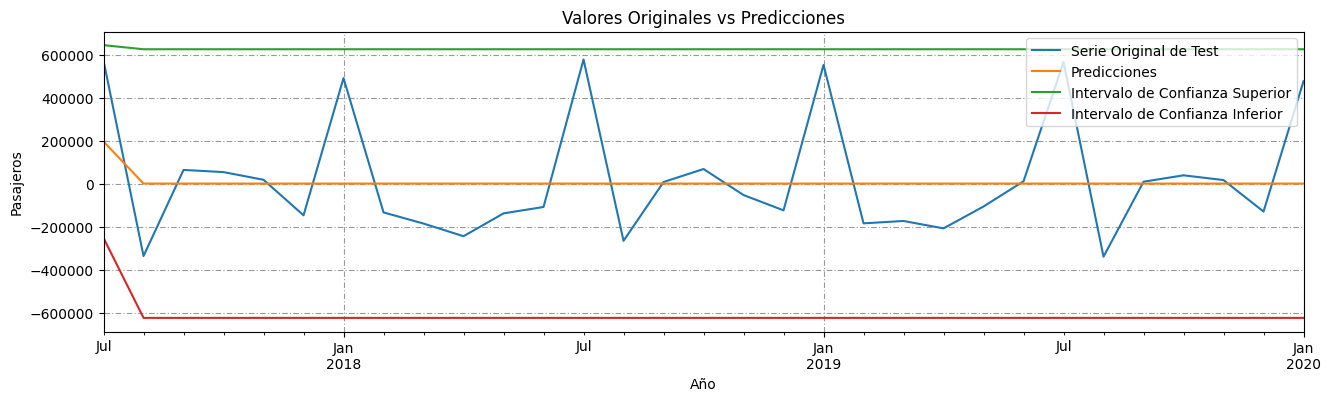

In [ ]:
# Utilizando el modelo realizamos la prediccion correspondiente al periodo de test
prediccionesARMA = resultadoARMA.get_forecast(len(test_diff_1))

# Graficamos la porcion de test de la serie original junto con las predicciones y los intervalos de confianza
graficar_pred(test_diff_1, prediccionesARMA.predicted_mean, prediccionesARMA.conf_int())

In [ ]:
evaluar_metricas(test_diff_1, prediccionesARMA.predicted_mean)

MSE: 71031187780.76657
MAE: 200274.4647098883
RMSE: 266516.7682919155
MAPE: 0.989


Hasta ahora, el modelo anterior es mejor porque tiene un MSE, RMSE y MAE mucho menores que este ultimo modelo lo que indica una mejor capacidad predictiva en términos absolutos.

# MODELO SARIMA

In [ ]:
# SARIMAX Model
sxmodel = auto_arima(train,
                    start_p=0,
                    start_q=0,
                    max_p=3,
                    max_q=3,
                    m=12,
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=2930.711, Time=0.25 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2934.811, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2916.116, Time=0.25 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2918.138, Time=0.25 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2935.126, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2926.962, Time=0.08 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2904.147, Time=0.68 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=2904.421, Time=1.32 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=2910.329, Time=0.60 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=2915.250, Time=0.44 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=2904.071, Time=2.22 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=2915.647, Time=2.06 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=2904.395, Time=1.40 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=2909.804, Time=0.48 sec
 ARIMA(3,0,0)(2,1,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  126
Model:             SARIMAX(2, 0, 1)x(2, 1, [], 12)   Log Likelihood               -1439.651
Date:                             Tue, 08 Oct 2024   AIC                           2891.302
Time:                                     23:45:57   BIC                           2907.719
Sample:                                 01-01-2007   HQIC                          2897.964
                                      - 06-01-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1563      0.080     14.537      0.000       1.000       1.312
ar.L2         -0.1890      0.072     -2.632      0.008      -0.330      -0.048
ma.L1         -0.9348      0.025    -36.688      0.000      -0.985      -0.885
ar.S.L12      -0.2315      0.052     -4.425      0.000      -0.334      -0.129
ar.S.L24      -0.1757      0.029     -6.043      0.000      -0.233      -0.119
sigma2      6.142e+09   1.14e-12    5.4e+21      0.000    6.14e+09    6.14e+09
===================================================================================
Ljung-Box (L1) (Q):                   1.07   Jarque-Bera (JB):                 0.34
Prob(Q):                              0.30   Prob(JB):                         0.84
Heteroskedasticity (H):               0.80   Skew:                            -0.11
Prob(H) (two-sided):                  0.51   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.47e+37. Standard errors may be unstable.
"""

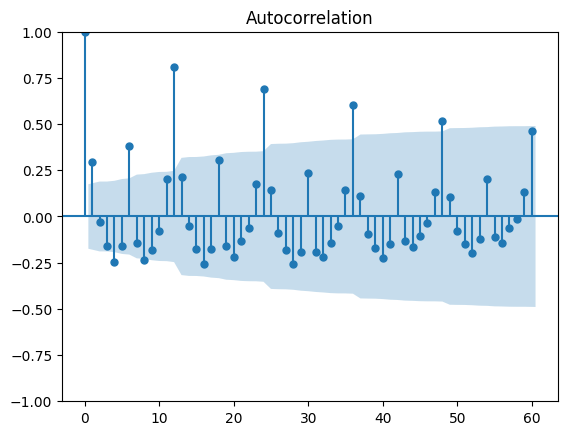

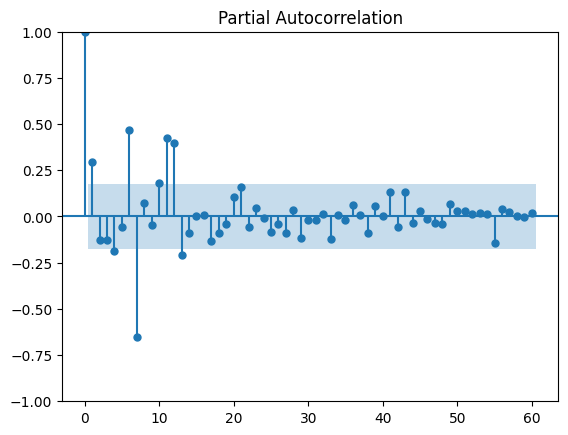

In [ ]:
plot_acf(train,lags=60);
plot_pacf(train,lags=60);

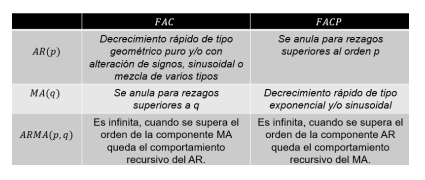

In [ ]:
# Dado que es una serie que presenta estacionalidad (seasonality) vamos a utilizar un modelo SARIMA que es una
# Arima que permite tratar el componente estacional . Los parametros del modelo son:

# SARIMA(p, d, q)(P, D, Q)m   order=(0,1,1), seasonal_order=(2,1,0,12))  SARIMAX(train, order=(0,1,1), seasonal_order=(2,1,0,12))
# Best model:  ARIMA(2,0,1)(2,1,0)[12]


modeloSARIMA2 = SARIMAX(train, order=(2,0,1), seasonal_order=(2,1,0,12))
modeloSARIMA2_fit = modeloSARIMA2.fit()
print(modeloSARIMA2_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            viajeros   No. Observations:                  126
Model:             SARIMAX(2, 0, 1)x(2, 1, [], 12)   Log Likelihood               -1439.651
Date:                             Tue, 08 Oct 2024   AIC                           2891.302
Time:                                     23:46:47   BIC                           2907.719
Sample:                                 01-01-2007   HQIC                          2897.964
                                      - 06-01-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1563      0.080     14.537      0.000       1.000       1.312
ar.L2         -0.1890      

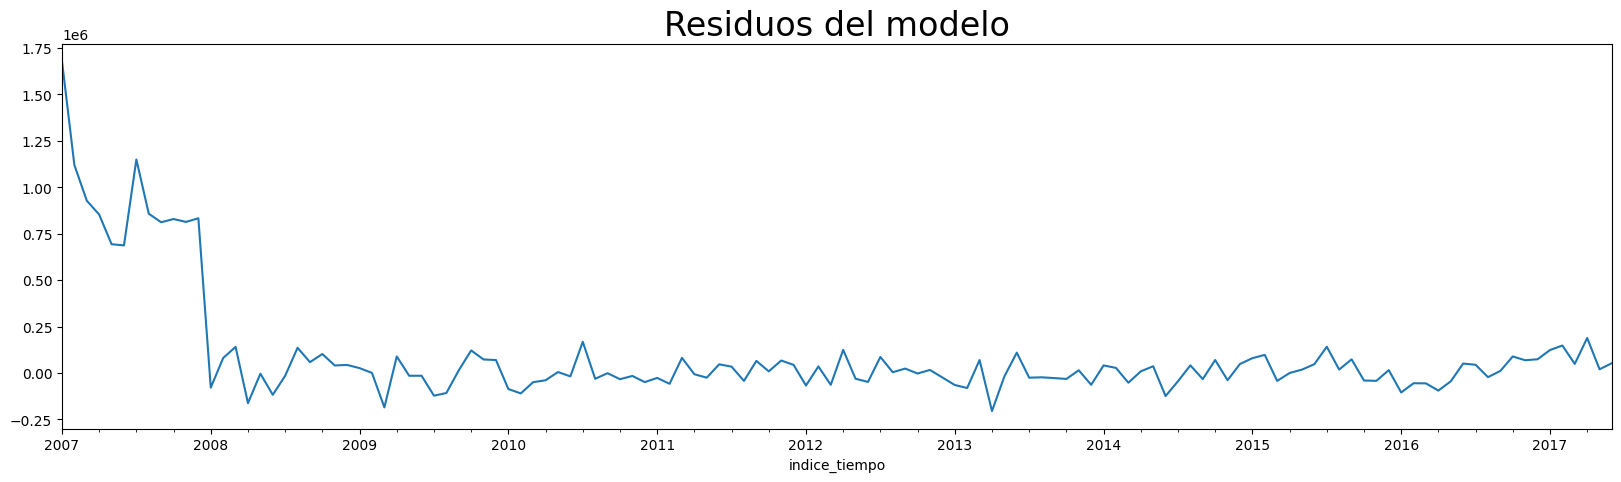

In [ ]:
modeloSARIMA2_fit.resid.plot(figsize=(20,5))
plt.title("Residuos del modelo",size=24)
plt.show()

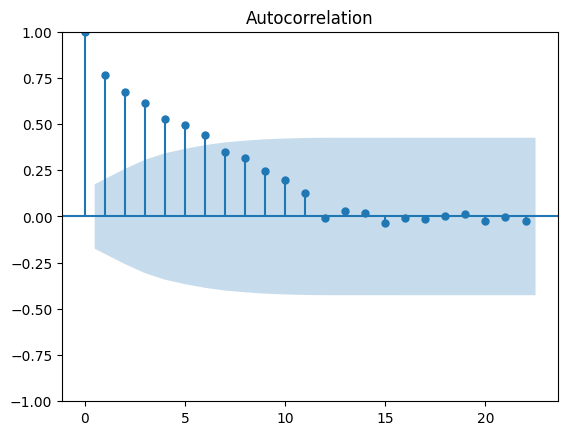

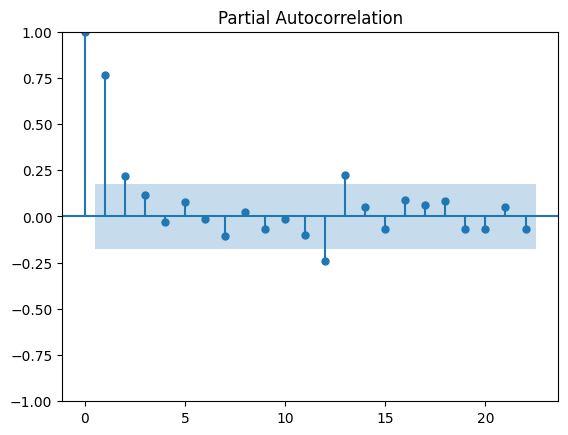

In [ ]:
plot_acf(modeloSARIMA2_fit.resid);
plot_pacf(modeloSARIMA2_fit.resid);

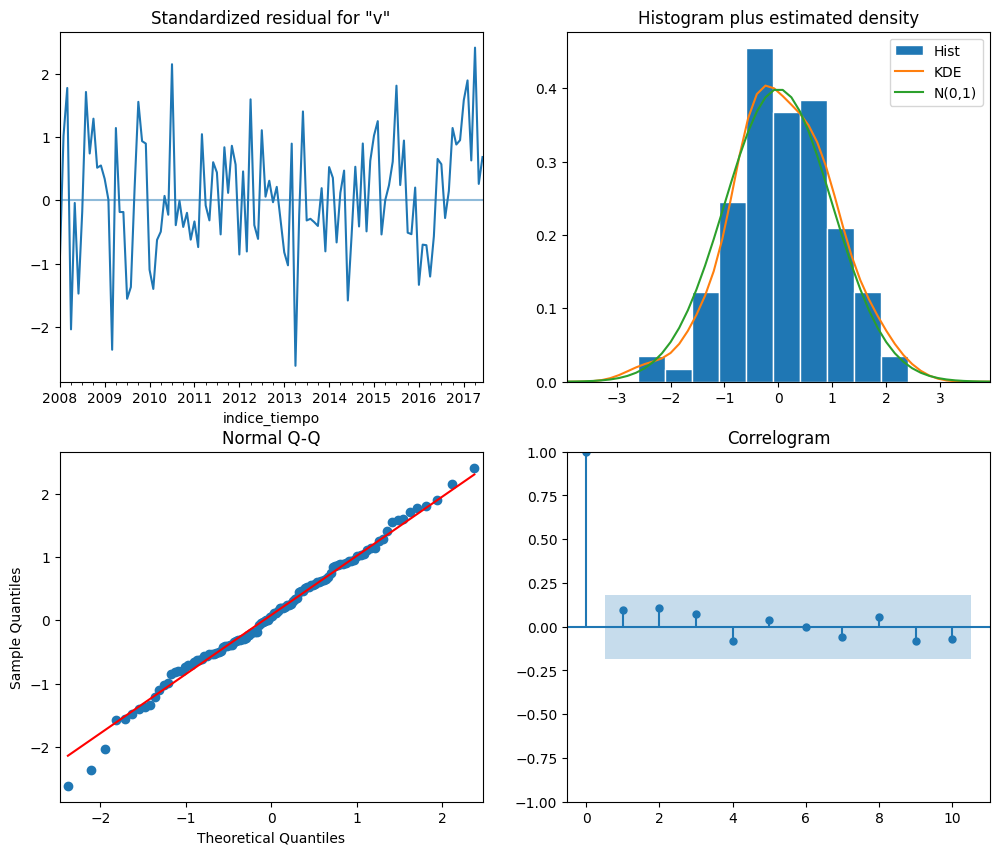

In [ ]:
# Diagnostico grafico los residuos del modelo
fig_res_2 = modeloSARIMA2_fit.plot_diagnostics(figsize=(12,10))

Text(0, 0.5, 'P-valores ')

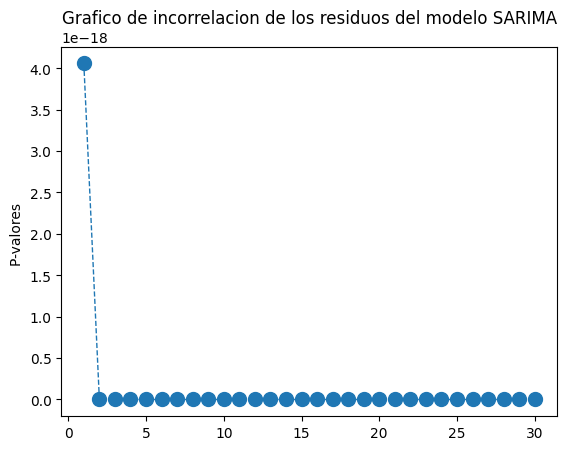

In [ ]:
Incorr_residuos_modelo_SARIMA2=sm.stats.acorr_ljungbox(modeloSARIMA2_fit.resid, lags=30)
plt.plot(Incorr_residuos_modelo_SARIMA2.lb_pvalue, marker='o', markersize=10, linestyle='--', linewidth=1)
plt.title("Grafico de incorrelacion de los residuos del modelo SARIMA")
plt.ylabel("P-valores ")

In [ ]:
modeloSARIMA = SARIMAX(train, order=(0,1,1), seasonal_order=(2,1,0,12))      # Mejor modelo segun autoarima = ARIMA(2,0,1)(2,1,0)[12]
modeloSARIMA_fit = modeloSARIMA.fit()
print(modeloSARIMA_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            viajeros   No. Observations:                  126
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood               -1441.402
Date:                             Tue, 08 Oct 2024   AIC                           2890.804
Time:                                     23:49:34   BIC                           2901.714
Sample:                                 01-01-2007   HQIC                          2895.231
                                      - 06-01-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1751      0.052     -3.381      0.001      -0.277      -0.074
ar.S.L12      -0.3414      

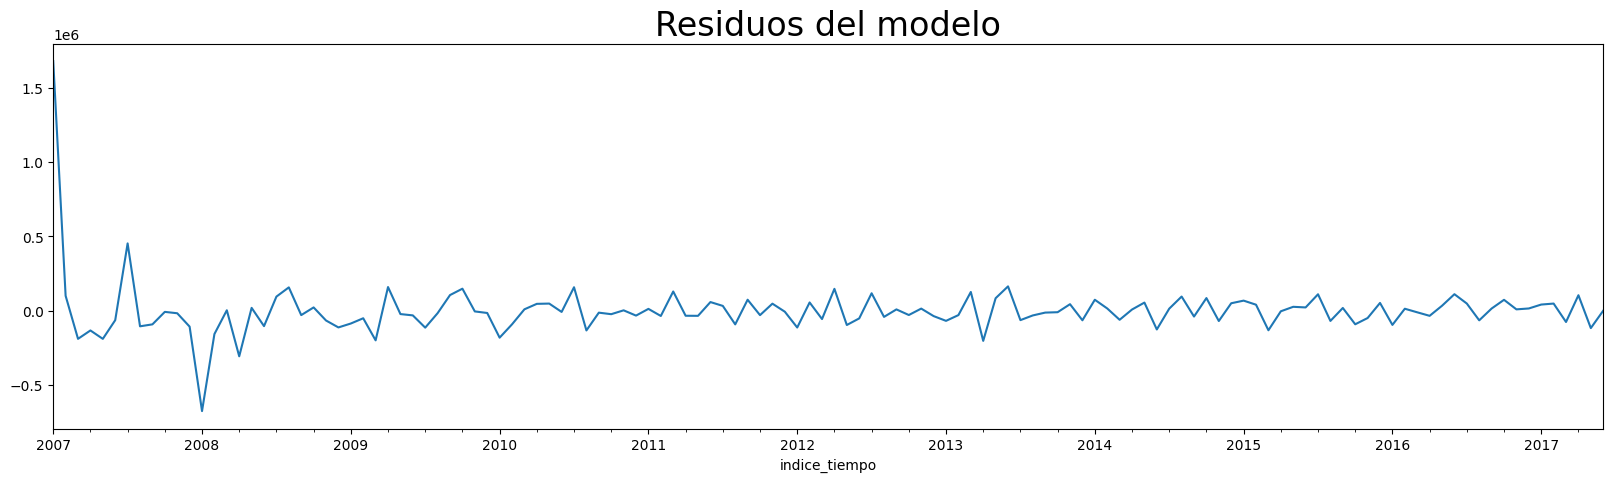

In [ ]:
modeloSARIMA_fit.resid.plot(figsize=(20,5))
plt.title("Residuos del modelo",size=24)
plt.show()

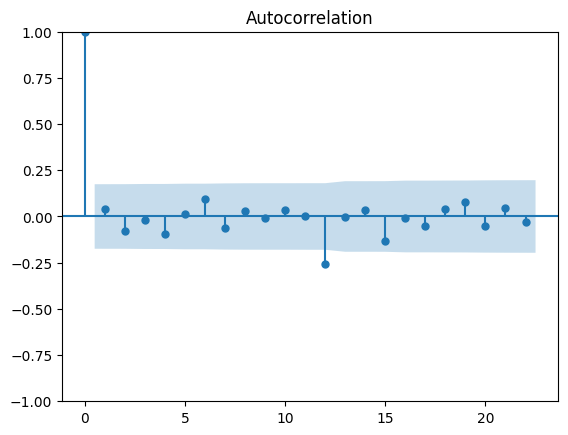

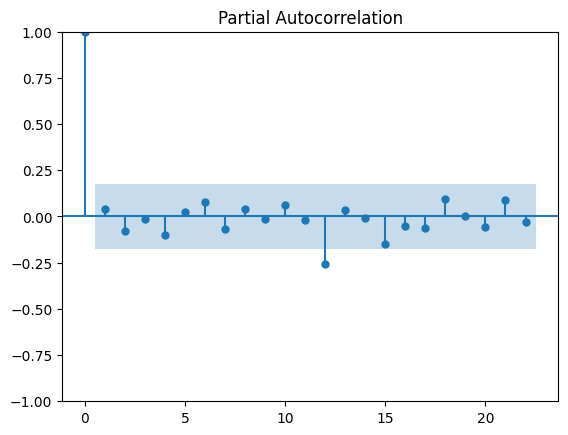

In [ ]:
plot_acf(modeloSARIMA_fit.resid);
plot_pacf(modeloSARIMA_fit.resid);

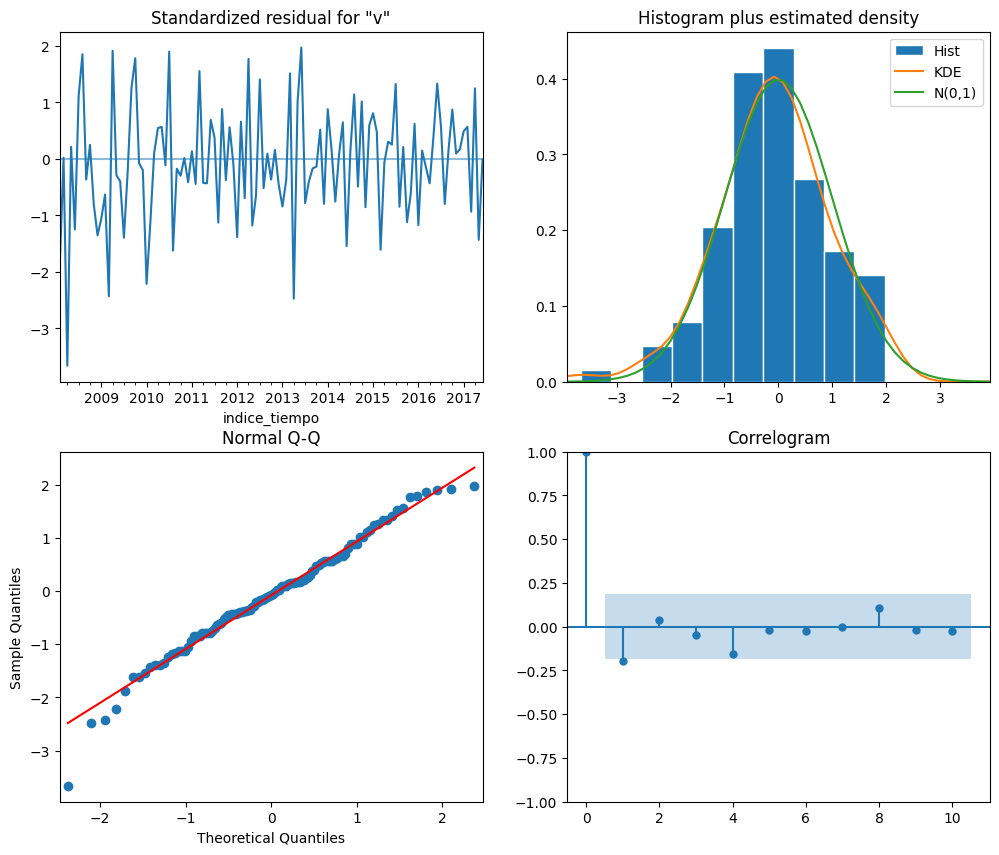

In [ ]:
# Diagnostico grafico los residuos del modelo
fig_res = modeloSARIMA_fit.plot_diagnostics(figsize=(12,10))

Text(0, 0.5, 'P-valores ')

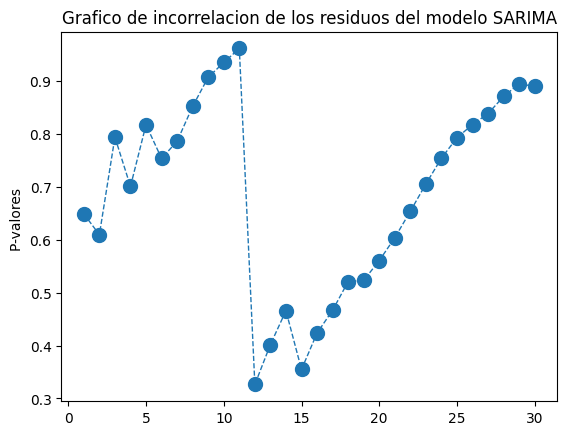

In [ ]:
Incorr_residuos_modelo_SARIMA2=sm.stats.acorr_ljungbox(modeloSARIMA_fit.resid, lags=30)
plt.plot(Incorr_residuos_modelo_SARIMA2.lb_pvalue, marker='o', markersize=10, linestyle='--', linewidth=1)
plt.title("Grafico de incorrelacion de los residuos del modelo SARIMA")
plt.ylabel("P-valores ")

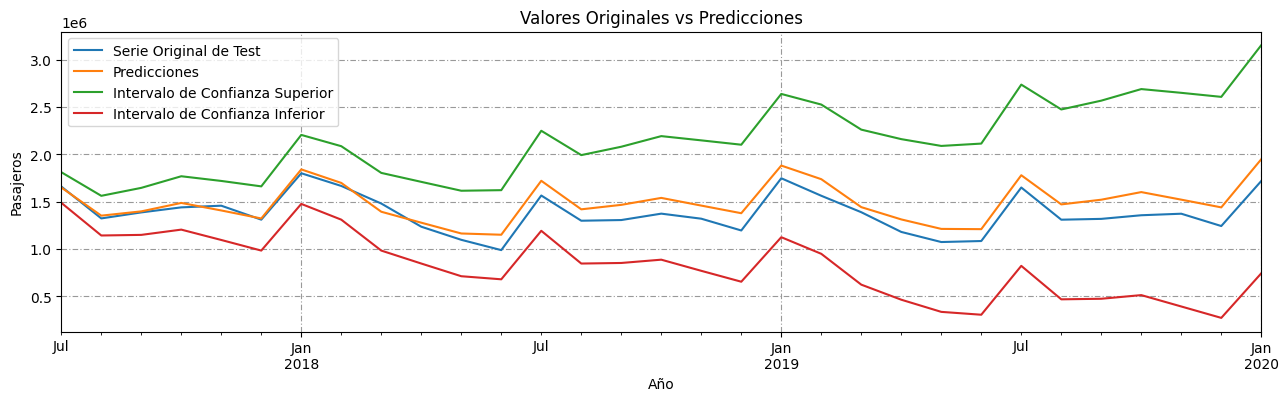

In [ ]:
# Utilizando el modelo realizamos la prediccion correspondiente al periodo de test
prediccionesSARIMA = modeloSARIMA_fit.get_forecast(len(test))

# Graficamos la porcion de test de la serie original junto con las predicciones y los intervalos de confianza
graficar_pred(test, prediccionesSARIMA.predicted_mean, prediccionesSARIMA.conf_int())

In [ ]:
print ("Modelo SARIMA((0,1,1),(2,1,0)")
evaluar_metricas(test, prediccionesSARIMA.predicted_mean)

Modelo SARIMA((0,1,1),(2,1,0)
MSE: 17930937666.744923
MAE: 115835.5608463674
RMSE: 133906.45117672606
MAPE: 0.0867


In [ ]:
# SARIMA(p, d, q)(P, D, Q)m  order=(0,1,1), seasonal_order=(2,1,0,12))

modeloSARIMA3 = SARIMAX(train, order=(0,2,1), seasonal_order=(2,1,0,12))
modeloSARIMA3_fit = modeloSARIMA3.fit()
print(modeloSARIMA3_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                      SARIMAX Results                                      
Dep. Variable:                            viajeros   No. Observations:                  126
Model:             SARIMAX(0, 2, 1)x(2, 1, [], 12)   Log Likelihood               -1438.628
Date:                             Tue, 08 Oct 2024   AIC                           2885.255
Time:                                     18:49:20   BIC                           2896.129
Sample:                                 01-01-2007   HQIC                          2889.667
                                      - 06-01-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9866      0.134     -7.342      0.000      -1.250      -0.723
ar.S.L12      -0.3886      

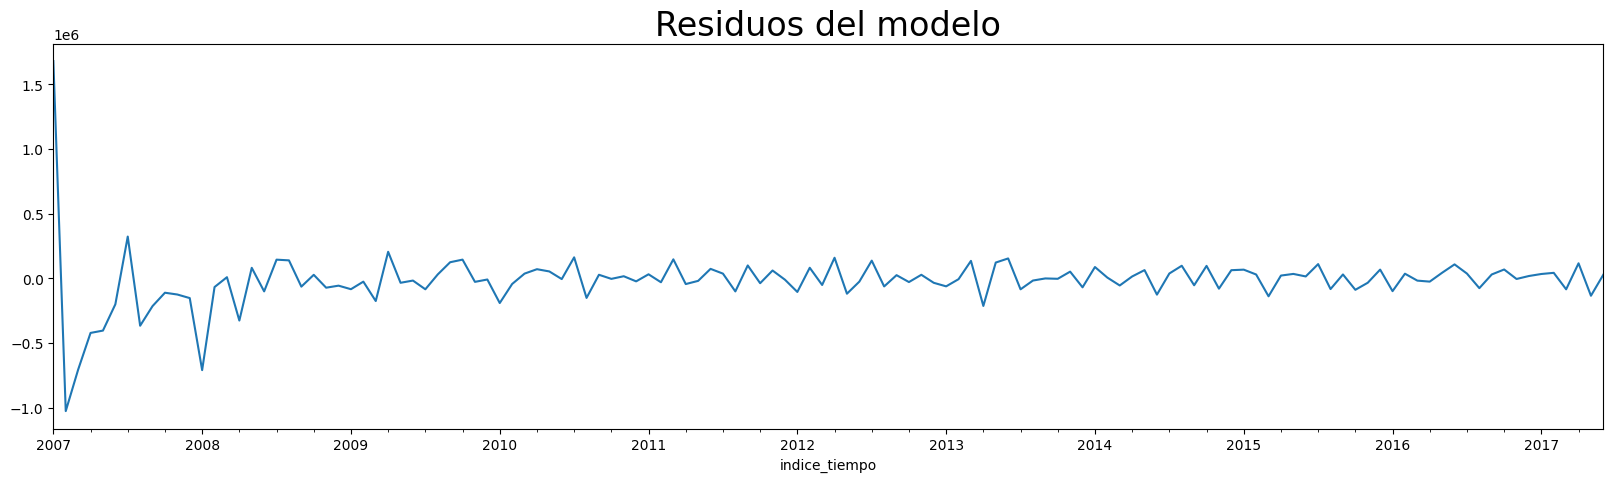

In [ ]:
modeloSARIMA3_fit.resid.plot(figsize=(20,5))
plt.title("Residuos del modelo",size=24)
plt.show()

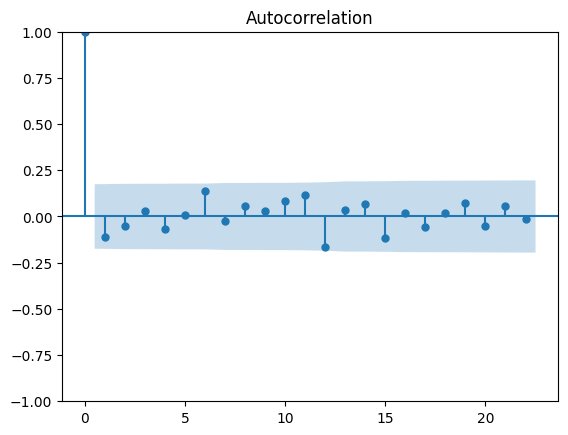

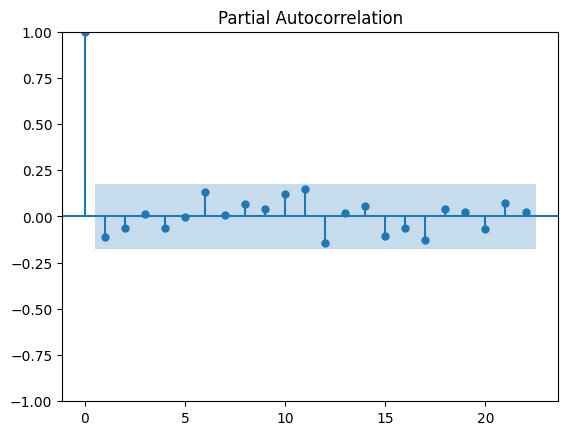

In [ ]:
plot_acf(modeloSARIMA3_fit.resid);
plot_pacf(modeloSARIMA3_fit.resid);

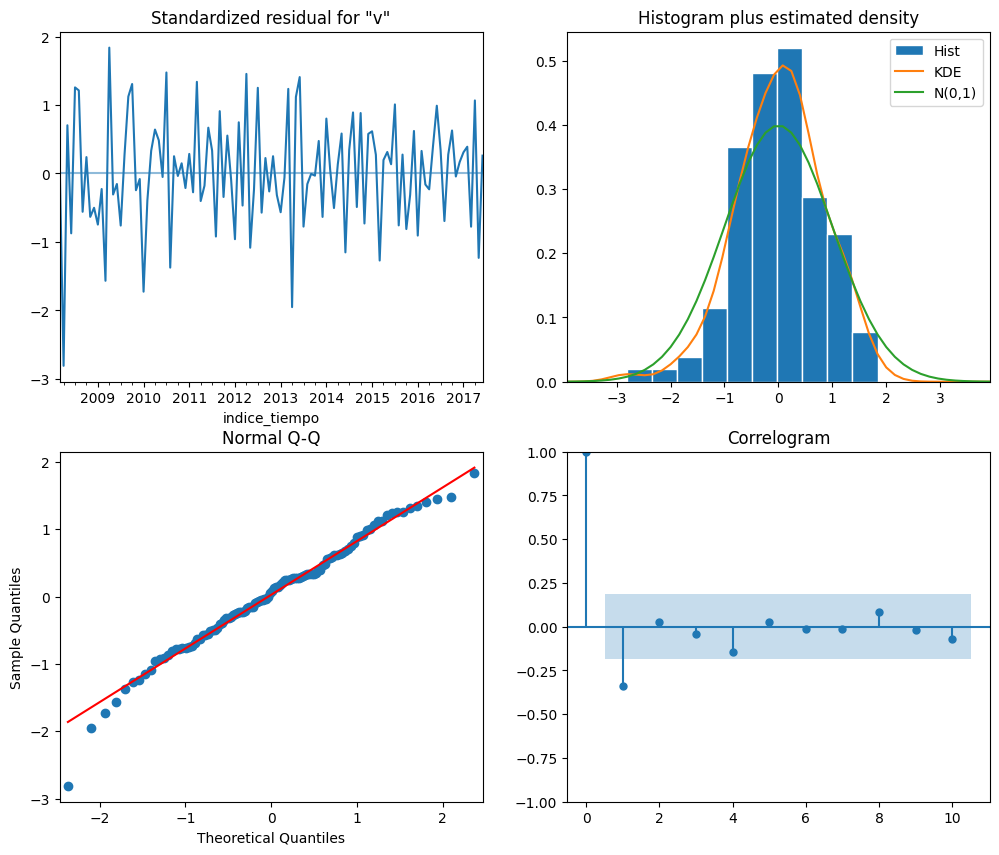

In [ ]:
# Diagnostico grafico los residuos del modelo
fig_res_3 = modeloSARIMA3_fit.plot_diagnostics(figsize=(12,10))

Text(0, 0.5, 'P-valores ')

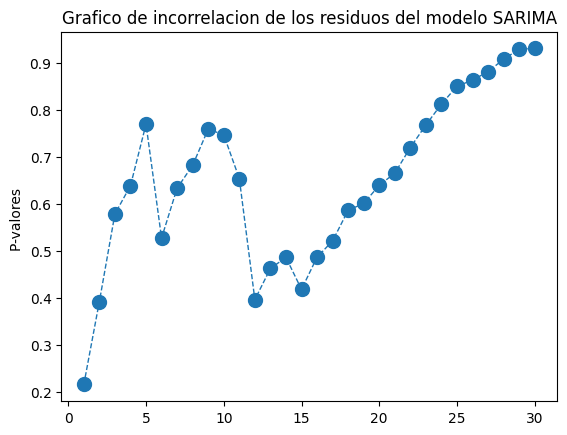

In [ ]:
Incorr_residuos_modelo_SARIMA3=sm.stats.acorr_ljungbox(modeloSARIMA3_fit.resid, lags=30)
plt.plot(Incorr_residuos_modelo_SARIMA3.lb_pvalue, marker='o', markersize=10, linestyle='--', linewidth=1)
plt.title("Grafico de incorrelacion de los residuos del modelo SARIMA")
plt.ylabel("P-valores ")

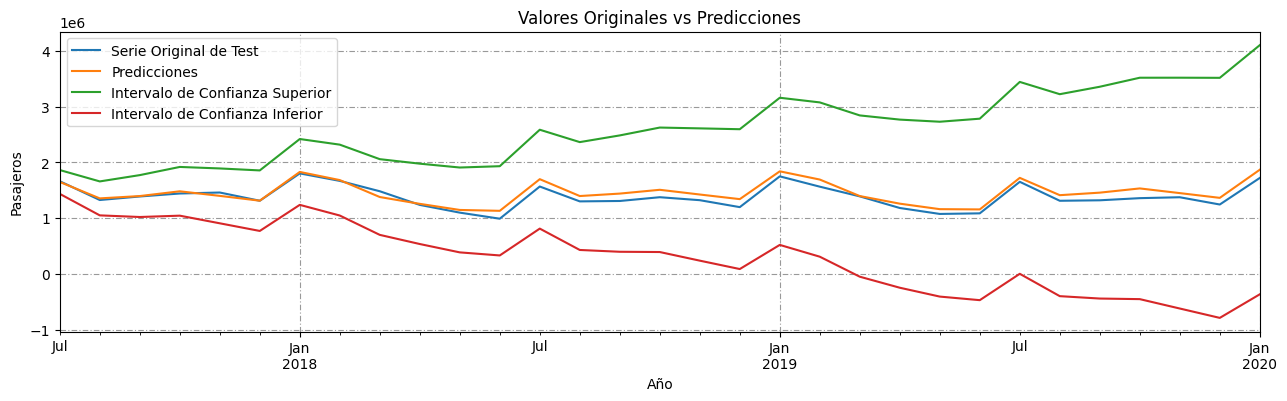

In [ ]:
# Utilizando el modelo realizamos la prediccion correspondiente al periodo de test
prediccionesSARIMA3 = modeloSARIMA3_fit.get_forecast(len(test))

# Graficamos la porcion de test de la serie original junto con las predicciones y los intervalos de confianza
graficar_pred(test, prediccionesSARIMA3.predicted_mean, prediccionesSARIMA3.conf_int())


In [ ]:
print("Modelo SARIMA((0,2,1),(2,1,0)")
evaluar_metricas(test, prediccionesSARIMA3.predicted_mean)

Modelo SARIMA((0,2,1),(2,1,0)
MSE: 9101281094.005793
MAE: 81412.39507478854
RMSE: 95400.6346624895
MAPE: 0.061


In [ ]:
# Ensemble ambos modelos
ensemble_pred = (prediccionesSARIMA.predicted_mean + prediccionesSARIMA3.predicted_mean) / 2

Intervalos de confianza

In [ ]:
# Obtener el intervalo de confianza modelo SARIMA 3
intervalo_confianza3 = prediccionesSARIMA3.conf_int()

# Seleccionar únicamente la columna "lower viajeros"
lower_viajeros3 = intervalo_confianza3['lower viajeros']

In [ ]:
# Obtener el intervalo de confianza modelo SARIMA 2
intervalo_confianza = prediccionesSARIMA.conf_int()

# Seleccionar únicamente la columna "lower viajeros"
lower_viajeros = intervalo_confianza['lower viajeros']

In [ ]:
# Obtener el intervalo de confianza modelo SARIMA 3
intervalo_confianza3 = prediccionesSARIMA3.conf_int()

# Seleccionar únicamente la columna "upper viajeros"
upper_viajeros3 = intervalo_confianza3['upper viajeros']

In [ ]:
# Obtener el intervalo de confianza modelo SARIMA 2
intervalo_confianza = prediccionesSARIMA.conf_int()

# Seleccionar únicamente la columna "upper viajeros"
upper_viajeros = intervalo_confianza['upper viajeros']

In [ ]:
# Promedio de las predicciones de ambos modelos
upper_viajeros_ensemble = (upper_viajeros + upper_viajeros3) / 2

In [ ]:
# Promedio de las predicciones de ambos modelos
lower_viajeros_ensemble = (lower_viajeros + lower_viajeros3) / 2

In [ ]:
serie1 = pd.Series(lower_viajeros_ensemble, index=lower_viajeros_ensemble.index)
serie2 = pd.Series(upper_viajeros_ensemble, index=upper_viajeros_ensemble.index)

# Crear un DataFrame combinando las dos series
df = pd.DataFrame({'lower viajeros': serie1, 'upper viajeros': serie2})

# Mostrar el DataFrame resultante
print(df)

            lower viajeros  upper viajeros
2017-07-01    1.461062e+06    1.836631e+06
2017-08-01    1.095449e+06    1.609727e+06
2017-09-01    1.083972e+06    1.708274e+06
2017-10-01    1.123832e+06    1.842954e+06
2017-11-01    1.000546e+06    1.804727e+06
2017-12-01    8.759471e+05    1.758277e+06
2018-01-01    1.356775e+06    2.312054e+06
2018-02-01    1.177706e+06    2.201857e+06
2018-03-01    8.406973e+05    1.930427e+06
2018-04-01    6.901597e+05    1.842743e+06
2018-05-01    5.480789e+05    1.761223e+06
2018-06-01    5.043307e+05    1.776077e+06
2018-07-01    1.001500e+06    2.417193e+06
2018-08-01    6.367969e+05    2.177571e+06
2018-09-01    6.235972e+05    2.281869e+06
2018-10-01    6.387127e+05    2.408424e+06
2018-11-01    5.024554e+05    2.378639e+06
2018-12-01    3.696029e+05    2.348106e+06
2019-01-01    8.214939e+05    2.898786e+06
2019-02-01    6.278379e+05    2.800883e+06
2019-03-01    2.854372e+05    2.551592e+06
2019-04-01    1.069013e+05    2.463846e+06
2019-05-01 

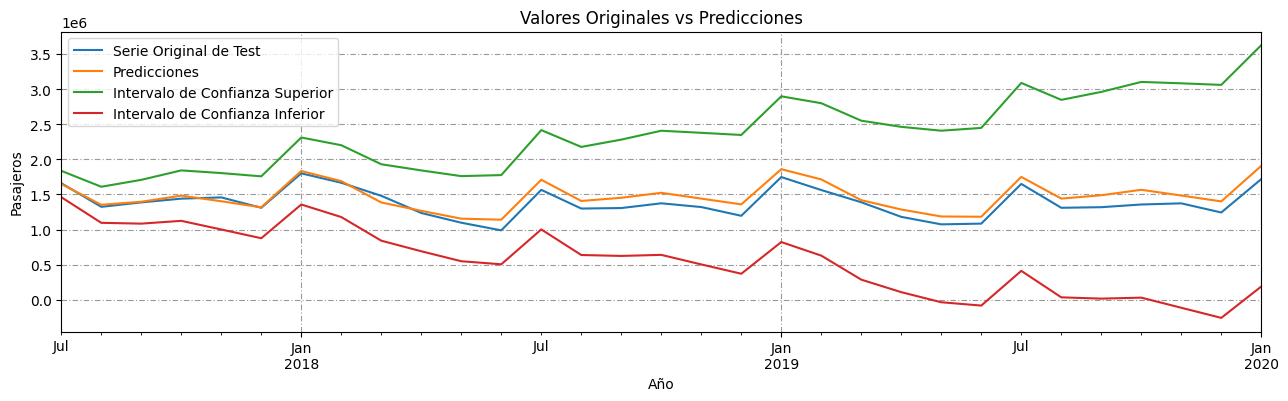

In [ ]:
# Graficamos la porcion de test de la serie original junto con las predicciones y los intervalos de confianza
graficar_pred(test, ensemble_pred, df)

In [ ]:
print("Metrica de el ensemble")
evaluar_metricas(test, ensemble_pred)

Metrica de el ensemble
MSE: 13043435899.472591
MAE: 98623.977960578
RMSE: 114207.86268673708
MAPE: 0.0739


Fin del codigo - Gracias